In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD


!pip install -q wordcloud
import wordcloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91960\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91960\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91960\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('../news/news.csv')

# Data Pre-processing

In [4]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
data = data.rename(columns = {'Unnamed: 0': 'Id'})

In [5]:
# Creating new feature : Number of words in news 'title'

def num_words(string):
    words = string.split()
    return len(words)

data['num_word_title'] = data['title'].apply(num_words)

print(data.groupby(data['label']).mean())

cols = ['title','num_word_title','text', 'label']
data = data[cols]

                Id  num_word_title
label                             
FAKE   7912.297092       11.133059
REAL   2654.344056        9.861243


In [6]:
data.head()

,title,num_word_title,text,label
0,You Can Smell Hillary’s Fear,5,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,14,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,9,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,15,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,9,It's primary day in New York and front-runners...,REAL


In [7]:
data[data['num_word_title']>25].groupby('label').count()    # This clearly shows if title length is more than 25, it's highly likely to be a fake news.

,title,num_word_title,text
label,,,
FAKE,31,31,31
REAL,1,1,1


In [8]:
def train_test_split(df, train_percent=.80, validate_percent=.20, seed=10):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [9]:
train, test = train_test_split(data[['num_word_title','text','label']], seed = 12)

In [10]:
train.shape, test.shape

((5068, 3), (1267, 3))

In [11]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


In [12]:
# CountVectorizer
count_vectorizer = CountVectorizer(stop_words = 'english', tokenizer=LemmaTokenizer(), 
                                   ngram_range = (1,2), dtype = np.uint8)

count_train = count_vectorizer.fit_transform(train['text'].values)

#check_train = count_train.toarray()
#feature_train = count_vectorizer.get_feature_names()


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
count_test = count_vectorizer.transform(test['text'].values)


In [ ]:
"""
We won't use TfidfVectorizer. However, if any one wants to use it, pre-processing step is similar.
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7, tokenizer=LemmaTokenizer(), 
                                   ngram_range = (1,2), dtype = np.float32)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(train['text'].values)
# Transform the test data
tfidf_test = tfidf_vectorizer.transform(test['text'].values)
"""

## Latent Semantic Analysis (Dimensionality Reduction)

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
lsa_count = TruncatedSVD(n_components = 400, random_state = 20)
lsa_count.fit(count_train)
print(lsa_count.explained_variance_ratio_.sum())          # Explained_variance = 84.66 %

0.8466047964079627


In [ ]:
#count_train_df = pd.DataFrame.sparse.from_spmatrix(count_train, columns = count_vectorizer.get_feature_names())

In [16]:
count_train_lsa = pd.DataFrame(lsa_count.transform(count_train))
count_test_lsa = pd.DataFrame(lsa_count.transform(count_test))

In [17]:
count_train_lsa['num_word_title'] = train['num_word_title'] / data['num_word_title'].max()
count_test_lsa['num_word_title'] = test['num_word_title'] / data['num_word_title'].max()

In [18]:
count_train_lsa.fillna(count_train_lsa.mean(), inplace = True)
count_test_lsa.fillna(count_test_lsa.mean(), inplace = True)

In [19]:
count_train_lsa.shape

(5068, 401)

# Naive-Bayes Model

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [30]:
# Trying out with Gaussian Naive Bayes and CountVectorizer model
params_NB = {'var_smoothing' : [1e-9, 1e-7, 1e-1]} # var_smoothing = 0.1 gives the best result.




In [ ]:
clf_NB = GridSearchCV(estimator = GaussianNB(),param_grid = params_NB, cv = 3, refit = True, scoring = 'accuracy', n_jobs = 4)

In [31]:
clf_NB.fit(count_train_lsa, train['label'])

GridSearchCV(cv=3, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=4,
             param_grid={'var_smoothing': [1e-09, 1e-07, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [32]:
clf_NB.best_params_

{'var_smoothing': 0.1}

In [33]:
clf_NB.best_score_

0.6369492586325487

In [34]:
test_count_pred_NB = clf_NB.predict(count_test_lsa)

In [35]:
accuracy_score(test['label'], test_count_pred_NB)

0.6187845303867403

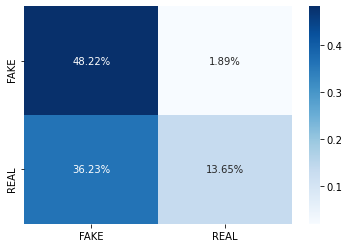

In [37]:
cm_NB = confusion_matrix(test['label'], test_count_pred_NB, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_NB/ np.sum(cm_NB),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [38]:
from sklearn.metrics import classification_report

count_report_NB = classification_report(test['label'], test_count_pred_NB, labels = ['FAKE','REAL'], output_dict = True)
count_report_NB = pd.DataFrame(count_report_NB).transpose()
count_report_NB

,precision,recall,f1-score,support
FAKE,0.571028,0.962205,0.716716,635.000000
REAL,0.878173,0.273734,0.417370,632.000000
accuracy,0.618785,0.618785,0.618785,0.618785
macro avg,0.724600,0.617969,0.567043,1267.000000
weighted avg,0.724237,0.618785,0.567397,1267.000000


# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression


In [45]:
params_LR = {'C' : [10, 5, 1,0.7, 0.5,0.3]}

# C = 0.5 gives the best result after Grid Search.



In [ ]:
clf_LR = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced', random_state = 6),param_grid = params_LR, 
                      cv = 3, refit = True, scoring = 'accuracy', n_jobs = 4)

In [46]:
clf_LR.fit(count_train_lsa, train['label'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=6, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [10, 5, 1, 0.7, 0.5, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [47]:
clf_LR.best_score_

0.8989736349484949

In [48]:
clf_LR.best_params_

{'C': 0.5}

In [49]:
test_count_pred_LR = clf_LR.predict(count_test_lsa)

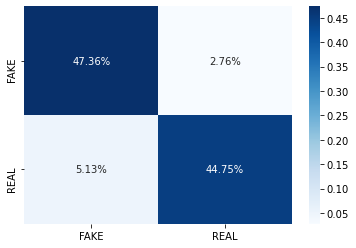

In [50]:
cm_LR = confusion_matrix(test['label'], test_count_pred_LR, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_LR/ np.sum(cm_LR),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [51]:
from sklearn.metrics import classification_report

count_report_LR = classification_report(test['label'], test_count_pred_LR, labels = ['FAKE','REAL'], output_dict = True)
count_report_LR = pd.DataFrame(count_report_LR).transpose()
count_report_LR

,precision,recall,f1-score,support
FAKE,0.902256,0.944882,0.923077,635.000000
REAL,0.941860,0.897152,0.918963,632.000000
accuracy,0.921073,0.921073,0.921073,0.921073
macro avg,0.922058,0.921017,0.921020,1267.000000
weighted avg,0.922011,0.921073,0.921025,1267.000000


# K-Nearest Neighbor Method

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
# params_knn = {'n_neighbors' : [2, 4, 8, 16] } # We obtain 4 as the best hyperparameter.
params_knn = {'n_neighbors' : [3,4,5,6,7] }     # 5 is the final tuned hyperparameter.

In [79]:
clf_knn = GridSearchCV(estimator = KNeighborsClassifier(algorithm = 'ball_tree'), param_grid = params_knn, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 3)

In [80]:
clf_knn.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   26.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [81]:
clf_knn.best_score_

0.8415551141333352

In [82]:
clf_knn.best_params_

{'n_neighbors': 5}

In [83]:
test_count_pred_knn = clf_knn.predict(count_test_lsa)

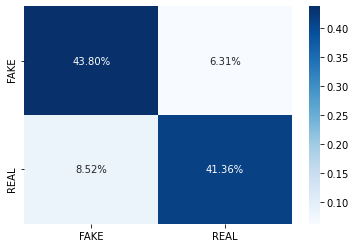

In [84]:
cm_knn = confusion_matrix(test['label'], test_count_pred_knn, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_knn/ np.sum(cm_knn),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [86]:
from sklearn.metrics import classification_report

count_report_knn = classification_report(test['label'], test_count_pred_knn, labels = ['FAKE','REAL'], output_dict = True)
count_report_knn = pd.DataFrame(count_report_knn).transpose()
count_report_knn

,precision,recall,f1-score,support
FAKE,0.837104,0.874016,0.855162,635.000000
REAL,0.867550,0.829114,0.847896,632.000000
accuracy,0.851618,0.851618,0.851618,0.851618
macro avg,0.852327,0.851565,0.851529,1267.000000
weighted avg,0.852291,0.851618,0.851538,1267.000000


# Support Vector Machine Classifier

In [96]:
from sklearn.svm import SVC

In [118]:
# params_svc = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : [0.1, 1, 50]} # 'rbf' and 50 give the best combination
# params_svc = {'kernel' : ['rbf', 'sigmoid'], 'C' : [10, 30, 50,100]}  # 100 and 'rbf' give the best combination.
params_svc = {'kernel' : ['rbf', 'sigmoid'], 'C' : [100, 150, 200]}   # 100 and 'rbf' give the best combination.

In [119]:
clf_svc = GridSearchCV(estimator = SVC(class_weight = 'balanced', random_state = 6), param_grid = params_svc, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [120]:
clf_svc.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   40.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=6, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [100, 150, 200], 'kernel': ['rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [121]:
clf_svc.best_params_

{'C': 100, 'kernel': 'rbf'}

In [122]:
clf_svc.best_score_

0.9031162306746402

In [123]:
test_count_pred_svc = clf_svc.predict(count_test_lsa)

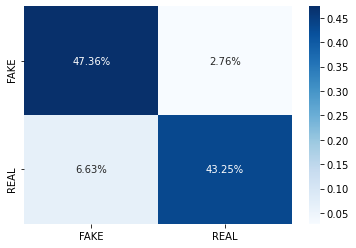

In [124]:
cm_svc = confusion_matrix(test['label'], test_count_pred_svc, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_svc/ np.sum(cm_svc),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [125]:
from sklearn.metrics import classification_report

count_report_svc = classification_report(test['label'], test_count_pred_svc, labels = ['FAKE','REAL'], output_dict = True)
count_report_svc = pd.DataFrame(count_report_svc).transpose()
count_report_svc

,precision,recall,f1-score,support
FAKE,0.877193,0.944882,0.909780,635.000000
REAL,0.939966,0.867089,0.902058,632.000000
accuracy,0.906077,0.906077,0.906077,0.906077
macro avg,0.908579,0.905985,0.905919,1267.000000
weighted avg,0.908505,0.906077,0.905928,1267.000000


# Linear Discriminant Analysis

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [128]:
params_LDA = {'solver' : ['svd', 'lsqr', 'eigen'], 'shrinkage' : ['auto', None]}

# (shrinkage = None and solver = svd) give the best result.

In [129]:
clf_LDA = GridSearchCV(estimator = LinearDiscriminantAnalysis(), param_grid = params_LDA, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [130]:
clf_LDA.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    6.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=4,
             param_grid={'shrinkage': ['auto', None],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [131]:
clf_LDA.best_params_

{'shrinkage': None, 'solver': 'svd'}

In [132]:
clf_LDA.best_score_

0.8646402116958204

In [133]:
test_count_pred_LDA = clf_LDA.predict(count_test_lsa)

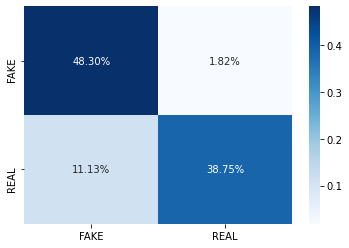

In [134]:
cm_LDA = confusion_matrix(test['label'], test_count_pred_LDA, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_LDA/ np.sum(cm_LDA),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [135]:
from sklearn.metrics import classification_report

count_report_LDA = classification_report(test['label'], test_count_pred_LDA, labels = ['FAKE','REAL'], output_dict = True)
count_report_LDA = pd.DataFrame(count_report_LDA).transpose()
count_report_LDA

,precision,recall,f1-score,support
FAKE,0.812749,0.963780,0.881844,635.00000
REAL,0.955253,0.776899,0.856894,632.00000
accuracy,0.870560,0.870560,0.870560,0.87056
macro avg,0.884001,0.870339,0.869369,1267.00000
weighted avg,0.883832,0.870560,0.869399,1267.00000


# Decision Tree Classifier

In [147]:
from sklearn.tree import DecisionTreeClassifier

In [149]:
params_dt = {'criterion' : ['entropy'], 'min_samples_split' : [2, 4, 8, 16, 32], 
             'min_samples_leaf' : [1,2,4,8],'max_depth' : [4, 7, 10], 'max_features' : ['sqrt', None],  'class_weight' : ['balanced']}

# (max_depth = 7, min_samples_leaf = 4, min_samples_split = 32, max_features = None) give the best result.

In [150]:
clf_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 7), param_grid = params_dt, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 3)

In [151]:
clf_dt.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=7, splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [4, 7, 10],

In [152]:
clf_dt.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 32}

In [153]:
clf_dt.best_score_

0.7940029638349081

In [154]:
test_count_pred_dt = clf_dt.predict(count_test_lsa)

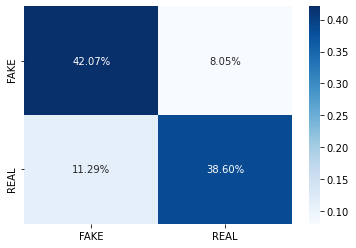

In [155]:
cm_dt = confusion_matrix(test['label'], test_count_pred_dt, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_dt/ np.sum(cm_dt),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [156]:
from sklearn.metrics import classification_report

count_report_dt = classification_report(test['label'], test_count_pred_dt, labels = ['FAKE','REAL'], output_dict = True)
count_report_dt = pd.DataFrame(count_report_dt).transpose()
count_report_dt

,precision,recall,f1-score,support
FAKE,0.788462,0.839370,0.813120,635.00000
REAL,0.827411,0.773734,0.799673,632.00000
accuracy,0.806630,0.806630,0.806630,0.80663
macro avg,0.807936,0.806552,0.806396,1267.00000
weighted avg,0.807890,0.806630,0.806412,1267.00000


# Random Forest Classifier

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
params_RF = {'n_estimators' : [400, 1000, 1600], 'criterion' : ['entropy'], 'min_samples_split' : [2, 4, 8, 16], 
             'min_samples_leaf' : [1,2], 'class_weight' : ['balanced']}  

# (min_samples_leaf = 1, min_samples_split = 4 , n_estimators = 1000) give the best result.

In [140]:
clf_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score = True, random_state = 7), param_grid = params_RF, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [141]:
clf_RF.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 34.4min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed: 74.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=7,
                                    

In [142]:
clf_RF.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [143]:
clf_RF.best_score_

0.860498900531692

In [144]:
test_count_pred_RF = clf_RF.predict(count_test_lsa)

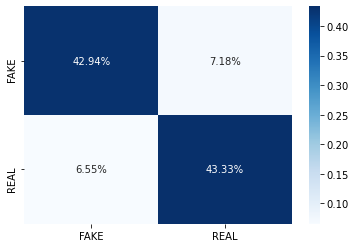

In [145]:
cm_RF = confusion_matrix(test['label'], test_count_pred_RF, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_RF/ np.sum(cm_RF),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [146]:
from sklearn.metrics import classification_report

count_report_RF = classification_report(test['label'], test_count_pred_RF, labels = ['FAKE','REAL'], output_dict = True)
count_report_RF = pd.DataFrame(count_report_RF).transpose()
count_report_RF

,precision,recall,f1-score,support
FAKE,0.867624,0.856693,0.862124,635.000000
REAL,0.857812,0.868671,0.863208,632.000000
accuracy,0.862668,0.862668,0.862668,0.862668
macro avg,0.862718,0.862682,0.862666,1267.000000
weighted avg,0.862730,0.862668,0.862664,1267.000000


# AdaBoost Classifier

In [157]:
from sklearn.ensemble import AdaBoostClassifier

In [166]:
# params_ada = {'n_estimators' : [50, 100, 500], 'learning_rate' : [1, 0.3]} # 500 and 1 give the best combination.
params_ada = {'n_estimators' : [500, 1000, 1500, 2000], 'learning_rate' : [1]}

In [167]:
clf_ada = GridSearchCV(estimator = AdaBoostClassifier(random_state = 8), param_grid = params_ada, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [168]:
clf_ada.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 30.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 30.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=8),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [1],
                         'n_estimators': [500, 1000, 1500, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [169]:
clf_ada.best_params_

{'learning_rate': 1, 'n_estimators': 1500}

In [170]:
clf_ada.best_score_

0.8985785737391149

In [171]:
test_count_pred_ada = clf_ada.predict(count_test_lsa)

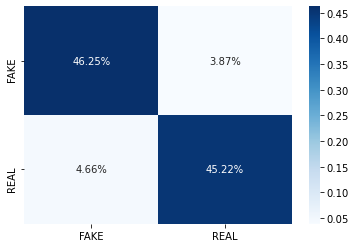

In [172]:
cm_ada = confusion_matrix(test['label'], test_count_pred_ada, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_ada/ np.sum(cm_ada),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [173]:
from sklearn.metrics import classification_report

count_report_ada = classification_report(test['label'], test_count_pred_ada, labels = ['FAKE','REAL'], output_dict = True)
count_report_ada = pd.DataFrame(count_report_ada).transpose()
count_report_ada

,precision,recall,f1-score,support
FAKE,0.908527,0.922835,0.915625,635.000000
REAL,0.921222,0.906646,0.913876,632.000000
accuracy,0.914759,0.914759,0.914759,0.914759
macro avg,0.914874,0.914740,0.914750,1267.000000
weighted avg,0.914859,0.914759,0.914752,1267.000000


# Light Gradient Boosting Method 

In [52]:
import lightgbm as lgb

In [61]:
#params_lgb = {'n_estimators' : [100, 400, 800], 'learning_rate' : [0.03, 0.1], 'min_child_samples' : [4, 12, 24]} # 800, 0.1 , 4 are the best ones.
#params_lgb = {'n_estimators' : [1200, 2400], 'learning_rate' : [ 0.1], 'min_child_samples' : [2,4]}  # 2400 and 2 are the best ones.
# Let's just try with n_estimators 3600.
params_lgb = {'n_estimators' : [3600], 'learning_rate' : [ 0.1], 'min_child_samples' : [1,2]} 
# (3600,0.1,1) hyperparameters perform best.

In [62]:
clf_lgb = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = params_lgb, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [63]:
clf_lgb.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [0.1], 'min_child_samples': [2],
                      

In [56]:
clf_lgb.best_params_

{'learning_rate': 0.1, 'min_child_samples': 2, 'n_estimators': 2400}

In [64]:
print(clf_lgb.best_score_)

0.9145621453587024


In [65]:
test_count_pred_lgb = clf_lgb.predict(count_test_lsa)   

print(confusion_matrix(test['label'], test_count_pred_lgb, labels = ['FAKE', 'REAL']))

[[599  36]
 [ 46 586]]


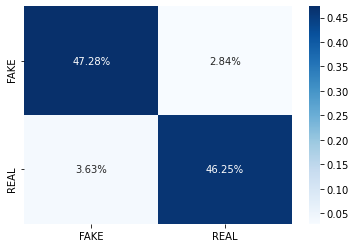

In [66]:
cm_lgb = confusion_matrix(test['label'], test_count_pred_lgb, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_lgb/ np.sum(cm_lgb),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [67]:
from sklearn.metrics import classification_report

count_report_lgb = classification_report(test['label'], test_count_pred_lgb, labels = ['FAKE','REAL'], output_dict = True)
count_report_lgb = pd.DataFrame(count_report_lgb).transpose()
count_report_lgb

,precision,recall,f1-score,support
FAKE,0.928682,0.943307,0.935937,635.00000
REAL,0.942122,0.927215,0.934609,632.00000
accuracy,0.935280,0.935280,0.935280,0.93528
macro avg,0.935402,0.935261,0.935273,1267.00000
weighted avg,0.935386,0.935280,0.935275,1267.00000


# CatBoosting

In [87]:
import catboost as cb

In [89]:
params_cat = {'n_estimators' : [800,1000, 2000] }   #  1000 is the best one

In [90]:
clf_cat = GridSearchCV(estimator = cb.CatBoostClassifier(task_type = 'GPU', learning_rate = 0.2, max_depth = 6), param_grid = params_cat,scoring = 'accuracy', n_jobs = 1,
                       cv = 3, refit = True, verbose = 2 )

In [91]:
clf_cat.fit(count_train_lsa, train['label'])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.5898072	total: 117ms	remaining: 1m 56s
1:	learn: 0.5296827	total: 177ms	remaining: 1m 28s
2:	learn: 0.4841578	total: 236ms	remaining: 1m 18s
3:	learn: 0.4429978	total: 293ms	remaining: 1m 12s
4:	learn: 0.4093052	total: 376ms	remaining: 1m 14s
5:	learn: 0.3922069	total: 470ms	remaining: 1m 17s
6:	learn: 0.3752167	total: 531ms	remaining: 1m 15s
7:	learn: 0.3604403	total: 583ms	remaining: 1m 12s
8:	learn: 0.3518327	total: 630ms	remaining: 1m 9s
9:	learn: 0.3391267	total: 678ms	remaining: 1m 7s
10:	learn: 0.3301590	total: 750ms	remaining: 1m 7s
11:	learn: 0.3222898	total: 799ms	remaining: 1m 5s
12:	learn: 0.3127565	total: 848ms	remaining: 1m 4s
13:	learn: 0.3070610	total: 897ms	remaining: 1m 3s
14:	learn: 0.3019376	total: 946ms	remaining: 1m 2s
15:	learn: 0.2934255	total: 994ms	remaining: 1m 1s
16:	learn: 0.2879832	total: 1.04s	remaining: 1m
17:	learn: 0.2797606	total: 1.09s	remaining: 59.6s
18:	learn: 0.2742239	total: 1.14s	remaining: 58.8s
19:	learn: 0.2706441	total: 1.19s	re

161:	learn: 0.0774249	total: 8.54s	remaining: 44.2s
162:	learn: 0.0774021	total: 8.59s	remaining: 44.1s
163:	learn: 0.0773839	total: 8.63s	remaining: 44s
164:	learn: 0.0773762	total: 8.68s	remaining: 43.9s
165:	learn: 0.0770055	total: 8.75s	remaining: 44s
166:	learn: 0.0759252	total: 8.8s	remaining: 43.9s
167:	learn: 0.0758890	total: 8.87s	remaining: 43.9s
168:	learn: 0.0742259	total: 8.92s	remaining: 43.9s
169:	learn: 0.0732581	total: 8.97s	remaining: 43.8s
170:	learn: 0.0732416	total: 9.02s	remaining: 43.7s
171:	learn: 0.0731302	total: 9.06s	remaining: 43.6s
172:	learn: 0.0721589	total: 9.11s	remaining: 43.6s
173:	learn: 0.0708353	total: 9.16s	remaining: 43.5s
174:	learn: 0.0695743	total: 9.21s	remaining: 43.4s
175:	learn: 0.0689232	total: 9.26s	remaining: 43.4s
176:	learn: 0.0689148	total: 9.31s	remaining: 43.3s
177:	learn: 0.0688865	total: 9.36s	remaining: 43.2s
178:	learn: 0.0688338	total: 9.4s	remaining: 43.1s
179:	learn: 0.0687050	total: 9.45s	remaining: 43.1s
180:	learn: 0.0686

323:	learn: 0.0442366	total: 16.4s	remaining: 34.2s
324:	learn: 0.0442280	total: 16.4s	remaining: 34.1s
325:	learn: 0.0442240	total: 16.5s	remaining: 34.1s
326:	learn: 0.0442225	total: 16.5s	remaining: 34s
327:	learn: 0.0442187	total: 16.6s	remaining: 34s
328:	learn: 0.0441892	total: 16.6s	remaining: 33.9s
329:	learn: 0.0441867	total: 16.7s	remaining: 33.9s
330:	learn: 0.0441859	total: 16.7s	remaining: 33.8s
331:	learn: 0.0441683	total: 16.8s	remaining: 33.8s
332:	learn: 0.0441665	total: 16.8s	remaining: 33.7s
333:	learn: 0.0441519	total: 16.9s	remaining: 33.6s
334:	learn: 0.0440960	total: 16.9s	remaining: 33.6s
335:	learn: 0.0440946	total: 17s	remaining: 33.5s
336:	learn: 0.0440921	total: 17s	remaining: 33.5s
337:	learn: 0.0440908	total: 17.1s	remaining: 33.4s
338:	learn: 0.0440675	total: 17.1s	remaining: 33.3s
339:	learn: 0.0440503	total: 17.1s	remaining: 33.3s
340:	learn: 0.0438436	total: 17.2s	remaining: 33.3s
341:	learn: 0.0438432	total: 17.3s	remaining: 33.2s
342:	learn: 0.043842

485:	learn: 0.0326488	total: 24.2s	remaining: 25.6s
486:	learn: 0.0324469	total: 24.2s	remaining: 25.5s
487:	learn: 0.0324424	total: 24.3s	remaining: 25.4s
488:	learn: 0.0324414	total: 24.3s	remaining: 25.4s
489:	learn: 0.0324004	total: 24.3s	remaining: 25.3s
490:	learn: 0.0323975	total: 24.4s	remaining: 25.3s
491:	learn: 0.0323961	total: 24.4s	remaining: 25.2s
492:	learn: 0.0319133	total: 24.5s	remaining: 25.2s
493:	learn: 0.0319120	total: 24.5s	remaining: 25.1s
494:	learn: 0.0319115	total: 24.6s	remaining: 25.1s
495:	learn: 0.0317270	total: 24.6s	remaining: 25s
496:	learn: 0.0317231	total: 24.7s	remaining: 25s
497:	learn: 0.0317221	total: 24.7s	remaining: 24.9s
498:	learn: 0.0317179	total: 24.8s	remaining: 24.9s
499:	learn: 0.0315941	total: 24.8s	remaining: 24.8s
500:	learn: 0.0315937	total: 24.9s	remaining: 24.8s
501:	learn: 0.0315895	total: 24.9s	remaining: 24.7s
502:	learn: 0.0315728	total: 25s	remaining: 24.7s
503:	learn: 0.0315511	total: 25s	remaining: 24.6s
504:	learn: 0.031550

648:	learn: 0.0244800	total: 31.8s	remaining: 17.2s
649:	learn: 0.0244782	total: 31.9s	remaining: 17.2s
650:	learn: 0.0244773	total: 31.9s	remaining: 17.1s
651:	learn: 0.0244707	total: 32s	remaining: 17.1s
652:	learn: 0.0244705	total: 32s	remaining: 17s
653:	learn: 0.0244649	total: 32.1s	remaining: 17s
654:	learn: 0.0244646	total: 32.1s	remaining: 16.9s
655:	learn: 0.0244638	total: 32.1s	remaining: 16.9s
656:	learn: 0.0244629	total: 32.2s	remaining: 16.8s
657:	learn: 0.0243662	total: 32.2s	remaining: 16.8s
658:	learn: 0.0243653	total: 32.3s	remaining: 16.7s
659:	learn: 0.0243530	total: 32.3s	remaining: 16.7s
660:	learn: 0.0243494	total: 32.4s	remaining: 16.6s
661:	learn: 0.0243282	total: 32.4s	remaining: 16.6s
662:	learn: 0.0243276	total: 32.5s	remaining: 16.5s
663:	learn: 0.0243258	total: 32.5s	remaining: 16.5s
664:	learn: 0.0243247	total: 32.6s	remaining: 16.4s
665:	learn: 0.0242911	total: 32.6s	remaining: 16.4s
666:	learn: 0.0242907	total: 32.7s	remaining: 16.3s
667:	learn: 0.024197

807:	learn: 0.0198190	total: 39.3s	remaining: 9.34s
808:	learn: 0.0198072	total: 39.4s	remaining: 9.29s
809:	learn: 0.0197987	total: 39.4s	remaining: 9.25s
810:	learn: 0.0197960	total: 39.5s	remaining: 9.2s
811:	learn: 0.0197946	total: 39.5s	remaining: 9.15s
812:	learn: 0.0197926	total: 39.6s	remaining: 9.1s
813:	learn: 0.0197891	total: 39.6s	remaining: 9.05s
814:	learn: 0.0197867	total: 39.7s	remaining: 9s
815:	learn: 0.0193994	total: 39.7s	remaining: 8.96s
816:	learn: 0.0193802	total: 39.8s	remaining: 8.91s
817:	learn: 0.0193759	total: 39.8s	remaining: 8.86s
818:	learn: 0.0192536	total: 39.9s	remaining: 8.81s
819:	learn: 0.0192530	total: 39.9s	remaining: 8.76s
820:	learn: 0.0190222	total: 40s	remaining: 8.71s
821:	learn: 0.0189730	total: 40s	remaining: 8.66s
822:	learn: 0.0189723	total: 40.1s	remaining: 8.61s
823:	learn: 0.0189716	total: 40.1s	remaining: 8.56s
824:	learn: 0.0188789	total: 40.1s	remaining: 8.52s
825:	learn: 0.0188727	total: 40.2s	remaining: 8.47s
826:	learn: 0.0188715

967:	learn: 0.0159489	total: 46.6s	remaining: 1.54s
968:	learn: 0.0159484	total: 46.7s	remaining: 1.49s
969:	learn: 0.0159481	total: 46.7s	remaining: 1.45s
970:	learn: 0.0159468	total: 46.8s	remaining: 1.4s
971:	learn: 0.0159465	total: 46.8s	remaining: 1.35s
972:	learn: 0.0159463	total: 46.9s	remaining: 1.3s
973:	learn: 0.0159224	total: 46.9s	remaining: 1.25s
974:	learn: 0.0159198	total: 47s	remaining: 1.2s
975:	learn: 0.0158741	total: 47s	remaining: 1.16s
976:	learn: 0.0158233	total: 47.1s	remaining: 1.11s
977:	learn: 0.0157364	total: 47.1s	remaining: 1.06s
978:	learn: 0.0157360	total: 47.2s	remaining: 1.01s
979:	learn: 0.0156996	total: 47.2s	remaining: 963ms
980:	learn: 0.0155143	total: 47.3s	remaining: 915ms
981:	learn: 0.0155058	total: 47.3s	remaining: 867ms
982:	learn: 0.0154642	total: 47.4s	remaining: 819ms
983:	learn: 0.0154637	total: 47.4s	remaining: 771ms
984:	learn: 0.0154575	total: 47.4s	remaining: 723ms
985:	learn: 0.0154574	total: 47.5s	remaining: 674ms
986:	learn: 0.01545

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


0:	learn: 0.5962557	total: 49.1ms	remaining: 49.1s
1:	learn: 0.5300322	total: 98ms	remaining: 48.9s
2:	learn: 0.4740558	total: 146ms	remaining: 48.5s
3:	learn: 0.4400933	total: 195ms	remaining: 48.5s
4:	learn: 0.4145471	total: 255ms	remaining: 50.7s
5:	learn: 0.3939528	total: 303ms	remaining: 50.1s
6:	learn: 0.3775052	total: 351ms	remaining: 49.8s
7:	learn: 0.3650631	total: 400ms	remaining: 49.6s
8:	learn: 0.3548788	total: 447ms	remaining: 49.3s
9:	learn: 0.3425637	total: 531ms	remaining: 52.6s
10:	learn: 0.3333623	total: 579ms	remaining: 52.1s
11:	learn: 0.3259181	total: 627ms	remaining: 51.6s
12:	learn: 0.3165792	total: 675ms	remaining: 51.3s
13:	learn: 0.3091094	total: 723ms	remaining: 50.9s
14:	learn: 0.3016791	total: 774ms	remaining: 50.8s
15:	learn: 0.2951357	total: 821ms	remaining: 50.5s
16:	learn: 0.2909863	total: 868ms	remaining: 50.2s
17:	learn: 0.2859442	total: 915ms	remaining: 49.9s
18:	learn: 0.2791749	total: 963ms	remaining: 49.7s
19:	learn: 0.2740544	total: 1.01s	remaini

163:	learn: 0.0870570	total: 8s	remaining: 40.8s
164:	learn: 0.0870458	total: 8.04s	remaining: 40.7s
165:	learn: 0.0870276	total: 8.09s	remaining: 40.7s
166:	learn: 0.0870264	total: 8.12s	remaining: 40.5s
167:	learn: 0.0870045	total: 8.16s	remaining: 40.4s
168:	learn: 0.0869963	total: 8.21s	remaining: 40.4s
169:	learn: 0.0863893	total: 8.26s	remaining: 40.3s
170:	learn: 0.0863817	total: 8.31s	remaining: 40.3s
171:	learn: 0.0863742	total: 8.35s	remaining: 40.2s
172:	learn: 0.0863475	total: 8.4s	remaining: 40.1s
173:	learn: 0.0863416	total: 8.45s	remaining: 40.1s
174:	learn: 0.0861733	total: 8.49s	remaining: 40s
175:	learn: 0.0861015	total: 8.54s	remaining: 40s
176:	learn: 0.0848007	total: 8.59s	remaining: 39.9s
177:	learn: 0.0847824	total: 8.63s	remaining: 39.9s
178:	learn: 0.0840236	total: 8.68s	remaining: 39.8s
179:	learn: 0.0839340	total: 8.73s	remaining: 39.8s
180:	learn: 0.0834574	total: 8.77s	remaining: 39.7s
181:	learn: 0.0833768	total: 8.82s	remaining: 39.6s
182:	learn: 0.083354

322:	learn: 0.0517518	total: 16.2s	remaining: 33.9s
323:	learn: 0.0517130	total: 16.2s	remaining: 33.8s
324:	learn: 0.0510967	total: 16.3s	remaining: 33.8s
325:	learn: 0.0510821	total: 16.3s	remaining: 33.7s
326:	learn: 0.0510802	total: 16.3s	remaining: 33.6s
327:	learn: 0.0509879	total: 16.4s	remaining: 33.6s
328:	learn: 0.0509780	total: 16.4s	remaining: 33.5s
329:	learn: 0.0509705	total: 16.5s	remaining: 33.5s
330:	learn: 0.0509690	total: 16.5s	remaining: 33.4s
331:	learn: 0.0506976	total: 16.6s	remaining: 33.4s
332:	learn: 0.0506879	total: 16.7s	remaining: 33.5s
333:	learn: 0.0506668	total: 16.8s	remaining: 33.6s
334:	learn: 0.0497019	total: 17s	remaining: 33.7s
335:	learn: 0.0496887	total: 17.1s	remaining: 33.8s
336:	learn: 0.0496883	total: 17.2s	remaining: 33.8s
337:	learn: 0.0496883	total: 17.2s	remaining: 33.8s
338:	learn: 0.0496771	total: 17.4s	remaining: 33.8s
339:	learn: 0.0496758	total: 17.4s	remaining: 33.8s
340:	learn: 0.0496679	total: 17.5s	remaining: 33.7s
341:	learn: 0.

485:	learn: 0.0375246	total: 24.3s	remaining: 25.7s
486:	learn: 0.0375239	total: 24.3s	remaining: 25.6s
487:	learn: 0.0375168	total: 24.4s	remaining: 25.6s
488:	learn: 0.0375160	total: 24.4s	remaining: 25.5s
489:	learn: 0.0372887	total: 24.5s	remaining: 25.5s
490:	learn: 0.0372797	total: 24.5s	remaining: 25.4s
491:	learn: 0.0372789	total: 24.6s	remaining: 25.4s
492:	learn: 0.0372594	total: 24.6s	remaining: 25.3s
493:	learn: 0.0372407	total: 24.7s	remaining: 25.3s
494:	learn: 0.0372259	total: 24.7s	remaining: 25.2s
495:	learn: 0.0372253	total: 24.8s	remaining: 25.2s
496:	learn: 0.0371786	total: 24.8s	remaining: 25.1s
497:	learn: 0.0371757	total: 24.8s	remaining: 25s
498:	learn: 0.0371748	total: 24.9s	remaining: 25s
499:	learn: 0.0371647	total: 24.9s	remaining: 24.9s
500:	learn: 0.0371645	total: 25s	remaining: 24.9s
501:	learn: 0.0371506	total: 25s	remaining: 24.8s
502:	learn: 0.0371305	total: 25.1s	remaining: 24.8s
503:	learn: 0.0371294	total: 25.1s	remaining: 24.7s
504:	learn: 0.036617

646:	learn: 0.0287814	total: 31.7s	remaining: 17.3s
647:	learn: 0.0287814	total: 31.7s	remaining: 17.2s
648:	learn: 0.0287793	total: 31.7s	remaining: 17.2s
649:	learn: 0.0287750	total: 31.8s	remaining: 17.1s
650:	learn: 0.0287736	total: 31.8s	remaining: 17.1s
651:	learn: 0.0287734	total: 31.9s	remaining: 17s
652:	learn: 0.0286355	total: 31.9s	remaining: 17s
653:	learn: 0.0285656	total: 32s	remaining: 16.9s
654:	learn: 0.0285653	total: 32s	remaining: 16.9s
655:	learn: 0.0285647	total: 32s	remaining: 16.8s
656:	learn: 0.0285646	total: 32.1s	remaining: 16.8s
657:	learn: 0.0285016	total: 32.1s	remaining: 16.7s
658:	learn: 0.0285010	total: 32.2s	remaining: 16.7s
659:	learn: 0.0284907	total: 32.2s	remaining: 16.6s
660:	learn: 0.0284907	total: 32.3s	remaining: 16.5s
661:	learn: 0.0284906	total: 32.3s	remaining: 16.5s
662:	learn: 0.0284876	total: 32.3s	remaining: 16.4s
663:	learn: 0.0284876	total: 32.4s	remaining: 16.4s
664:	learn: 0.0284876	total: 32.4s	remaining: 16.3s
665:	learn: 0.0284861	

806:	learn: 0.0229702	total: 38.9s	remaining: 9.31s
807:	learn: 0.0229702	total: 39s	remaining: 9.26s
808:	learn: 0.0229695	total: 39s	remaining: 9.21s
809:	learn: 0.0229695	total: 39s	remaining: 9.15s
810:	learn: 0.0229694	total: 39s	remaining: 9.1s
811:	learn: 0.0229568	total: 39.1s	remaining: 9.05s
812:	learn: 0.0228457	total: 39.1s	remaining: 9s
813:	learn: 0.0228439	total: 39.2s	remaining: 8.96s
814:	learn: 0.0228438	total: 39.2s	remaining: 8.91s
815:	learn: 0.0228437	total: 39.3s	remaining: 8.86s
816:	learn: 0.0228396	total: 39.3s	remaining: 8.81s
817:	learn: 0.0228396	total: 39.3s	remaining: 8.75s
818:	learn: 0.0228275	total: 39.4s	remaining: 8.7s
819:	learn: 0.0228139	total: 39.4s	remaining: 8.66s
820:	learn: 0.0228127	total: 39.5s	remaining: 8.61s
821:	learn: 0.0228000	total: 39.5s	remaining: 8.56s
822:	learn: 0.0227999	total: 39.6s	remaining: 8.51s
823:	learn: 0.0227986	total: 39.6s	remaining: 8.46s
824:	learn: 0.0227986	total: 39.6s	remaining: 8.41s
825:	learn: 0.0227471	tot

967:	learn: 0.0185597	total: 46.2s	remaining: 1.53s
968:	learn: 0.0185366	total: 46.3s	remaining: 1.48s
969:	learn: 0.0185357	total: 46.3s	remaining: 1.43s
970:	learn: 0.0185346	total: 46.4s	remaining: 1.38s
971:	learn: 0.0185346	total: 46.4s	remaining: 1.34s
972:	learn: 0.0184533	total: 46.4s	remaining: 1.29s
973:	learn: 0.0184530	total: 46.5s	remaining: 1.24s
974:	learn: 0.0184382	total: 46.5s	remaining: 1.19s
975:	learn: 0.0184382	total: 46.6s	remaining: 1.14s
976:	learn: 0.0184382	total: 46.6s	remaining: 1.1s
977:	learn: 0.0184336	total: 46.6s	remaining: 1.05s
978:	learn: 0.0184261	total: 46.7s	remaining: 1s
979:	learn: 0.0184237	total: 46.7s	remaining: 953ms
980:	learn: 0.0184202	total: 46.8s	remaining: 906ms
981:	learn: 0.0183846	total: 46.8s	remaining: 858ms
982:	learn: 0.0183727	total: 46.9s	remaining: 810ms
983:	learn: 0.0183724	total: 46.9s	remaining: 763ms
984:	learn: 0.0183721	total: 47s	remaining: 715ms
985:	learn: 0.0183718	total: 47s	remaining: 667ms
986:	learn: 0.018233

125:	learn: 0.1041119	total: 5.96s	remaining: 41.3s
126:	learn: 0.1024759	total: 6s	remaining: 41.3s
127:	learn: 0.1018867	total: 6.05s	remaining: 41.2s
128:	learn: 0.1018703	total: 6.1s	remaining: 41.2s
129:	learn: 0.1012582	total: 6.14s	remaining: 41.1s
130:	learn: 0.1012382	total: 6.22s	remaining: 41.3s
131:	learn: 0.1012084	total: 6.29s	remaining: 41.3s
132:	learn: 0.0988055	total: 6.34s	remaining: 41.3s
133:	learn: 0.0987799	total: 6.42s	remaining: 41.5s
134:	learn: 0.0986351	total: 6.47s	remaining: 41.5s
135:	learn: 0.0985445	total: 6.52s	remaining: 41.4s
136:	learn: 0.0976849	total: 6.56s	remaining: 41.4s
137:	learn: 0.0976817	total: 6.58s	remaining: 41.1s
138:	learn: 0.0974655	total: 6.64s	remaining: 41.1s
139:	learn: 0.0967734	total: 6.69s	remaining: 41.1s
140:	learn: 0.0951563	total: 6.74s	remaining: 41.1s
141:	learn: 0.0951285	total: 6.79s	remaining: 41s
142:	learn: 0.0942778	total: 6.83s	remaining: 41s
143:	learn: 0.0930890	total: 6.88s	remaining: 40.9s
144:	learn: 0.092829

285:	learn: 0.0568688	total: 13.4s	remaining: 33.6s
286:	learn: 0.0564424	total: 13.5s	remaining: 33.5s
287:	learn: 0.0564042	total: 13.5s	remaining: 33.5s
288:	learn: 0.0564013	total: 13.6s	remaining: 33.4s
289:	learn: 0.0554804	total: 13.6s	remaining: 33.4s
290:	learn: 0.0554764	total: 13.7s	remaining: 33.3s
291:	learn: 0.0554057	total: 13.7s	remaining: 33.3s
292:	learn: 0.0553794	total: 13.8s	remaining: 33.2s
293:	learn: 0.0553774	total: 13.8s	remaining: 33.2s
294:	learn: 0.0553752	total: 13.9s	remaining: 33.1s
295:	learn: 0.0553706	total: 13.9s	remaining: 33.1s
296:	learn: 0.0545495	total: 14s	remaining: 33.1s
297:	learn: 0.0543567	total: 14s	remaining: 33s
298:	learn: 0.0530860	total: 14.1s	remaining: 33s
299:	learn: 0.0530661	total: 14.1s	remaining: 33s
300:	learn: 0.0524657	total: 14.2s	remaining: 32.9s
301:	learn: 0.0524640	total: 14.2s	remaining: 32.9s
302:	learn: 0.0514519	total: 14.3s	remaining: 32.8s
303:	learn: 0.0509056	total: 14.3s	remaining: 32.8s
304:	learn: 0.0508808	

445:	learn: 0.0373426	total: 20.9s	remaining: 25.9s
446:	learn: 0.0373379	total: 20.9s	remaining: 25.9s
447:	learn: 0.0373342	total: 20.9s	remaining: 25.8s
448:	learn: 0.0373326	total: 21s	remaining: 25.8s
449:	learn: 0.0373320	total: 21.1s	remaining: 25.8s
450:	learn: 0.0373275	total: 21.1s	remaining: 25.7s
451:	learn: 0.0371533	total: 21.2s	remaining: 25.7s
452:	learn: 0.0371382	total: 21.2s	remaining: 25.7s
453:	learn: 0.0371357	total: 21.3s	remaining: 25.6s
454:	learn: 0.0368345	total: 21.4s	remaining: 25.6s
455:	learn: 0.0368255	total: 21.4s	remaining: 25.6s
456:	learn: 0.0368186	total: 21.5s	remaining: 25.5s
457:	learn: 0.0368181	total: 21.5s	remaining: 25.5s
458:	learn: 0.0368174	total: 21.6s	remaining: 25.4s
459:	learn: 0.0365442	total: 21.6s	remaining: 25.4s
460:	learn: 0.0365343	total: 21.7s	remaining: 25.3s
461:	learn: 0.0365122	total: 21.7s	remaining: 25.3s
462:	learn: 0.0362616	total: 21.8s	remaining: 25.3s
463:	learn: 0.0362585	total: 21.8s	remaining: 25.2s
464:	learn: 0.

605:	learn: 0.0286289	total: 28.9s	remaining: 18.8s
606:	learn: 0.0286151	total: 29s	remaining: 18.7s
607:	learn: 0.0286122	total: 29s	remaining: 18.7s
608:	learn: 0.0286116	total: 29s	remaining: 18.6s
609:	learn: 0.0284192	total: 29.1s	remaining: 18.6s
610:	learn: 0.0284185	total: 29.2s	remaining: 18.6s
611:	learn: 0.0284159	total: 29.3s	remaining: 18.5s
612:	learn: 0.0279041	total: 29.3s	remaining: 18.5s
613:	learn: 0.0279034	total: 29.4s	remaining: 18.5s
614:	learn: 0.0278994	total: 29.4s	remaining: 18.4s
615:	learn: 0.0278804	total: 29.4s	remaining: 18.4s
616:	learn: 0.0278498	total: 29.5s	remaining: 18.3s
617:	learn: 0.0278480	total: 29.5s	remaining: 18.3s
618:	learn: 0.0278479	total: 29.6s	remaining: 18.2s
619:	learn: 0.0278454	total: 29.6s	remaining: 18.1s
620:	learn: 0.0278447	total: 29.7s	remaining: 18.1s
621:	learn: 0.0278444	total: 29.7s	remaining: 18s
622:	learn: 0.0277996	total: 29.8s	remaining: 18s
623:	learn: 0.0277990	total: 29.8s	remaining: 18s
624:	learn: 0.0277985	to

765:	learn: 0.0202850	total: 36.6s	remaining: 11.2s
766:	learn: 0.0202848	total: 36.6s	remaining: 11.1s
767:	learn: 0.0202847	total: 36.6s	remaining: 11.1s
768:	learn: 0.0202844	total: 36.7s	remaining: 11s
769:	learn: 0.0202754	total: 36.7s	remaining: 11s
770:	learn: 0.0202753	total: 36.8s	remaining: 10.9s
771:	learn: 0.0199189	total: 36.8s	remaining: 10.9s
772:	learn: 0.0198973	total: 36.9s	remaining: 10.8s
773:	learn: 0.0198956	total: 36.9s	remaining: 10.8s
774:	learn: 0.0198947	total: 36.9s	remaining: 10.7s
775:	learn: 0.0198944	total: 37s	remaining: 10.7s
776:	learn: 0.0198934	total: 37s	remaining: 10.6s
777:	learn: 0.0198924	total: 37.1s	remaining: 10.6s
778:	learn: 0.0198802	total: 37.1s	remaining: 10.5s
779:	learn: 0.0198796	total: 37.2s	remaining: 10.5s
780:	learn: 0.0198765	total: 37.2s	remaining: 10.4s
781:	learn: 0.0198681	total: 37.3s	remaining: 10.4s
782:	learn: 0.0198681	total: 37.3s	remaining: 10.3s
783:	learn: 0.0198680	total: 37.3s	remaining: 10.3s
784:	learn: 0.019866

924:	learn: 0.0167607	total: 43.5s	remaining: 3.53s
925:	learn: 0.0167600	total: 43.6s	remaining: 3.48s
926:	learn: 0.0167594	total: 43.6s	remaining: 3.44s
927:	learn: 0.0165838	total: 43.7s	remaining: 3.39s
928:	learn: 0.0165838	total: 43.7s	remaining: 3.34s
929:	learn: 0.0165838	total: 43.7s	remaining: 3.29s
930:	learn: 0.0165831	total: 43.8s	remaining: 3.24s
931:	learn: 0.0165830	total: 43.8s	remaining: 3.19s
932:	learn: 0.0165808	total: 43.8s	remaining: 3.15s
933:	learn: 0.0165805	total: 43.9s	remaining: 3.1s
934:	learn: 0.0165795	total: 43.9s	remaining: 3.06s
935:	learn: 0.0165745	total: 44s	remaining: 3.01s
936:	learn: 0.0165741	total: 44s	remaining: 2.96s
937:	learn: 0.0165247	total: 44.1s	remaining: 2.91s
938:	learn: 0.0165247	total: 44.1s	remaining: 2.87s
939:	learn: 0.0165247	total: 44.1s	remaining: 2.82s
940:	learn: 0.0165227	total: 44.2s	remaining: 2.77s
941:	learn: 0.0165224	total: 44.2s	remaining: 2.72s
942:	learn: 0.0165221	total: 44.3s	remaining: 2.68s
943:	learn: 0.016

82:	learn: 0.1210817	total: 4.09s	remaining: 1m 34s
83:	learn: 0.1190286	total: 4.14s	remaining: 1m 34s
84:	learn: 0.1188553	total: 4.18s	remaining: 1m 34s
85:	learn: 0.1177537	total: 4.23s	remaining: 1m 34s
86:	learn: 0.1155530	total: 4.28s	remaining: 1m 34s
87:	learn: 0.1152135	total: 4.33s	remaining: 1m 34s
88:	learn: 0.1151767	total: 4.37s	remaining: 1m 33s
89:	learn: 0.1151285	total: 4.42s	remaining: 1m 33s
90:	learn: 0.1148518	total: 4.46s	remaining: 1m 33s
91:	learn: 0.1143619	total: 4.51s	remaining: 1m 33s
92:	learn: 0.1143353	total: 4.56s	remaining: 1m 33s
93:	learn: 0.1138219	total: 4.61s	remaining: 1m 33s
94:	learn: 0.1133376	total: 4.66s	remaining: 1m 33s
95:	learn: 0.1126731	total: 4.7s	remaining: 1m 33s
96:	learn: 0.1110633	total: 4.75s	remaining: 1m 33s
97:	learn: 0.1095493	total: 4.8s	remaining: 1m 33s
98:	learn: 0.1087123	total: 4.85s	remaining: 1m 33s
99:	learn: 0.1073370	total: 4.9s	remaining: 1m 33s
100:	learn: 0.1071736	total: 4.95s	remaining: 1m 33s
101:	learn: 0.

240:	learn: 0.0541213	total: 11.6s	remaining: 1m 24s
241:	learn: 0.0540555	total: 11.7s	remaining: 1m 24s
242:	learn: 0.0540545	total: 11.7s	remaining: 1m 24s
243:	learn: 0.0537282	total: 11.8s	remaining: 1m 24s
244:	learn: 0.0534655	total: 11.8s	remaining: 1m 24s
245:	learn: 0.0533160	total: 11.9s	remaining: 1m 24s
246:	learn: 0.0533138	total: 11.9s	remaining: 1m 24s
247:	learn: 0.0532825	total: 11.9s	remaining: 1m 24s
248:	learn: 0.0532551	total: 12s	remaining: 1m 24s
249:	learn: 0.0532523	total: 12s	remaining: 1m 24s
250:	learn: 0.0532440	total: 12.1s	remaining: 1m 24s
251:	learn: 0.0527369	total: 12.1s	remaining: 1m 24s
252:	learn: 0.0527306	total: 12.2s	remaining: 1m 24s
253:	learn: 0.0527234	total: 12.2s	remaining: 1m 24s
254:	learn: 0.0523331	total: 12.3s	remaining: 1m 23s
255:	learn: 0.0523089	total: 12.3s	remaining: 1m 23s
256:	learn: 0.0515384	total: 12.4s	remaining: 1m 23s
257:	learn: 0.0515353	total: 12.4s	remaining: 1m 23s
258:	learn: 0.0508373	total: 12.5s	remaining: 1m 2

399:	learn: 0.0391281	total: 19.1s	remaining: 1m 16s
400:	learn: 0.0391205	total: 19.1s	remaining: 1m 16s
401:	learn: 0.0391194	total: 19.1s	remaining: 1m 16s
402:	learn: 0.0391192	total: 19.2s	remaining: 1m 16s
403:	learn: 0.0391136	total: 19.2s	remaining: 1m 15s
404:	learn: 0.0391105	total: 19.3s	remaining: 1m 15s
405:	learn: 0.0390820	total: 19.3s	remaining: 1m 15s
406:	learn: 0.0390780	total: 19.4s	remaining: 1m 15s
407:	learn: 0.0390752	total: 19.4s	remaining: 1m 15s
408:	learn: 0.0390608	total: 19.5s	remaining: 1m 15s
409:	learn: 0.0390231	total: 19.5s	remaining: 1m 15s
410:	learn: 0.0389914	total: 19.6s	remaining: 1m 15s
411:	learn: 0.0389900	total: 19.6s	remaining: 1m 15s
412:	learn: 0.0389391	total: 19.7s	remaining: 1m 15s
413:	learn: 0.0389319	total: 19.7s	remaining: 1m 15s
414:	learn: 0.0381937	total: 19.7s	remaining: 1m 15s
415:	learn: 0.0380425	total: 19.8s	remaining: 1m 15s
416:	learn: 0.0374214	total: 19.8s	remaining: 1m 15s
417:	learn: 0.0373552	total: 19.9s	remaining: 

556:	learn: 0.0286260	total: 26.5s	remaining: 1m 8s
557:	learn: 0.0286013	total: 26.5s	remaining: 1m 8s
558:	learn: 0.0285836	total: 26.6s	remaining: 1m 8s
559:	learn: 0.0285818	total: 26.6s	remaining: 1m 8s
560:	learn: 0.0285809	total: 26.7s	remaining: 1m 8s
561:	learn: 0.0278788	total: 26.7s	remaining: 1m 8s
562:	learn: 0.0278666	total: 26.8s	remaining: 1m 8s
563:	learn: 0.0278643	total: 26.8s	remaining: 1m 8s
564:	learn: 0.0278636	total: 26.9s	remaining: 1m 8s
565:	learn: 0.0278610	total: 26.9s	remaining: 1m 8s
566:	learn: 0.0275217	total: 27s	remaining: 1m 8s
567:	learn: 0.0271113	total: 27s	remaining: 1m 8s
568:	learn: 0.0270944	total: 27.1s	remaining: 1m 8s
569:	learn: 0.0269269	total: 27.1s	remaining: 1m 7s
570:	learn: 0.0269241	total: 27.1s	remaining: 1m 7s
571:	learn: 0.0269223	total: 27.2s	remaining: 1m 7s
572:	learn: 0.0269121	total: 27.2s	remaining: 1m 7s
573:	learn: 0.0269061	total: 27.3s	remaining: 1m 7s
574:	learn: 0.0268095	total: 27.3s	remaining: 1m 7s
575:	learn: 0.02

716:	learn: 0.0231198	total: 33.8s	remaining: 1m
717:	learn: 0.0231056	total: 33.9s	remaining: 1m
718:	learn: 0.0230304	total: 33.9s	remaining: 1m
719:	learn: 0.0230163	total: 34.1s	remaining: 1m
720:	learn: 0.0227652	total: 34.3s	remaining: 1m
721:	learn: 0.0227402	total: 34.4s	remaining: 1m
722:	learn: 0.0227397	total: 34.5s	remaining: 1m
723:	learn: 0.0227373	total: 34.7s	remaining: 1m 1s
724:	learn: 0.0227364	total: 34.8s	remaining: 1m 1s
725:	learn: 0.0226561	total: 34.8s	remaining: 1m 1s
726:	learn: 0.0226452	total: 34.9s	remaining: 1m 1s
727:	learn: 0.0226413	total: 34.9s	remaining: 1m
728:	learn: 0.0225080	total: 35s	remaining: 1m
729:	learn: 0.0225040	total: 35s	remaining: 1m
730:	learn: 0.0225027	total: 35s	remaining: 1m
731:	learn: 0.0224803	total: 35.1s	remaining: 1m
732:	learn: 0.0224802	total: 35.1s	remaining: 1m
733:	learn: 0.0224747	total: 35.2s	remaining: 1m
734:	learn: 0.0224709	total: 35.2s	remaining: 1m
735:	learn: 0.0224251	total: 35.3s	remaining: 1m
736:	learn: 0.

881:	learn: 0.0180521	total: 42.8s	remaining: 54.3s
882:	learn: 0.0180362	total: 42.9s	remaining: 54.2s
883:	learn: 0.0180348	total: 42.9s	remaining: 54.2s
884:	learn: 0.0180345	total: 43s	remaining: 54.1s
885:	learn: 0.0180335	total: 43s	remaining: 54.1s
886:	learn: 0.0180272	total: 43.1s	remaining: 54s
887:	learn: 0.0180007	total: 43.1s	remaining: 54s
888:	learn: 0.0179795	total: 43.2s	remaining: 53.9s
889:	learn: 0.0179792	total: 43.2s	remaining: 53.9s
890:	learn: 0.0179767	total: 43.2s	remaining: 53.8s
891:	learn: 0.0178204	total: 43.3s	remaining: 53.8s
892:	learn: 0.0178198	total: 43.4s	remaining: 53.8s
893:	learn: 0.0177416	total: 43.4s	remaining: 53.7s
894:	learn: 0.0177405	total: 43.5s	remaining: 53.7s
895:	learn: 0.0177404	total: 43.5s	remaining: 53.6s
896:	learn: 0.0177401	total: 43.6s	remaining: 53.6s
897:	learn: 0.0177400	total: 43.6s	remaining: 53.5s
898:	learn: 0.0177396	total: 43.6s	remaining: 53.4s
899:	learn: 0.0177395	total: 43.6s	remaining: 53.3s
900:	learn: 0.017739

1041:	learn: 0.0145344	total: 50.5s	remaining: 46.4s
1042:	learn: 0.0145344	total: 50.5s	remaining: 46.4s
1043:	learn: 0.0144506	total: 50.6s	remaining: 46.3s
1044:	learn: 0.0143605	total: 50.6s	remaining: 46.3s
1045:	learn: 0.0143598	total: 50.7s	remaining: 46.2s
1046:	learn: 0.0143587	total: 50.7s	remaining: 46.2s
1047:	learn: 0.0143583	total: 50.8s	remaining: 46.1s
1048:	learn: 0.0143571	total: 50.8s	remaining: 46.1s
1049:	learn: 0.0143570	total: 50.8s	remaining: 46s
1050:	learn: 0.0143570	total: 50.9s	remaining: 45.9s
1051:	learn: 0.0143570	total: 50.9s	remaining: 45.9s
1052:	learn: 0.0143569	total: 51s	remaining: 45.8s
1053:	learn: 0.0143542	total: 51s	remaining: 45.8s
1054:	learn: 0.0143541	total: 51s	remaining: 45.7s
1055:	learn: 0.0143526	total: 51.1s	remaining: 45.7s
1056:	learn: 0.0143509	total: 51.1s	remaining: 45.6s
1057:	learn: 0.0143241	total: 51.2s	remaining: 45.6s
1058:	learn: 0.0143238	total: 51.2s	remaining: 45.5s
1059:	learn: 0.0143228	total: 51.3s	remaining: 45.5s
1

1200:	learn: 0.0113606	total: 58s	remaining: 38.6s
1201:	learn: 0.0112638	total: 58s	remaining: 38.5s
1202:	learn: 0.0112588	total: 58.1s	remaining: 38.5s
1203:	learn: 0.0112551	total: 58.1s	remaining: 38.4s
1204:	learn: 0.0111563	total: 58.2s	remaining: 38.4s
1205:	learn: 0.0111539	total: 58.2s	remaining: 38.3s
1206:	learn: 0.0111527	total: 58.3s	remaining: 38.3s
1207:	learn: 0.0111525	total: 58.3s	remaining: 38.2s
1208:	learn: 0.0111523	total: 58.4s	remaining: 38.2s
1209:	learn: 0.0111427	total: 58.4s	remaining: 38.1s
1210:	learn: 0.0111406	total: 58.5s	remaining: 38.1s
1211:	learn: 0.0111183	total: 58.5s	remaining: 38.1s
1212:	learn: 0.0111099	total: 58.6s	remaining: 38s
1213:	learn: 0.0110222	total: 58.6s	remaining: 38s
1214:	learn: 0.0110211	total: 58.7s	remaining: 37.9s
1215:	learn: 0.0110119	total: 58.7s	remaining: 37.9s
1216:	learn: 0.0110119	total: 58.8s	remaining: 37.8s
1217:	learn: 0.0110115	total: 58.8s	remaining: 37.8s
1218:	learn: 0.0110061	total: 58.9s	remaining: 37.7s
1

1361:	learn: 0.0092739	total: 1m 5s	remaining: 30.7s
1362:	learn: 0.0092344	total: 1m 5s	remaining: 30.7s
1363:	learn: 0.0092306	total: 1m 5s	remaining: 30.6s
1364:	learn: 0.0092268	total: 1m 5s	remaining: 30.6s
1365:	learn: 0.0092250	total: 1m 5s	remaining: 30.5s
1366:	learn: 0.0091806	total: 1m 5s	remaining: 30.5s
1367:	learn: 0.0091800	total: 1m 5s	remaining: 30.4s
1368:	learn: 0.0091773	total: 1m 5s	remaining: 30.4s
1369:	learn: 0.0091754	total: 1m 5s	remaining: 30.3s
1370:	learn: 0.0091753	total: 1m 6s	remaining: 30.3s
1371:	learn: 0.0091718	total: 1m 6s	remaining: 30.2s
1372:	learn: 0.0091713	total: 1m 6s	remaining: 30.2s
1373:	learn: 0.0091709	total: 1m 6s	remaining: 30.1s
1374:	learn: 0.0091692	total: 1m 6s	remaining: 30.1s
1375:	learn: 0.0091688	total: 1m 6s	remaining: 30s
1376:	learn: 0.0091616	total: 1m 6s	remaining: 30s
1377:	learn: 0.0090806	total: 1m 6s	remaining: 29.9s
1378:	learn: 0.0090793	total: 1m 6s	remaining: 29.9s
1379:	learn: 0.0090791	total: 1m 6s	remaining: 29.

1519:	learn: 0.0079412	total: 1m 13s	remaining: 23.1s
1520:	learn: 0.0079408	total: 1m 13s	remaining: 23.1s
1521:	learn: 0.0079394	total: 1m 13s	remaining: 23s
1522:	learn: 0.0079393	total: 1m 13s	remaining: 23s
1523:	learn: 0.0079370	total: 1m 13s	remaining: 22.9s
1524:	learn: 0.0079365	total: 1m 13s	remaining: 22.9s
1525:	learn: 0.0079362	total: 1m 13s	remaining: 22.8s
1526:	learn: 0.0079362	total: 1m 13s	remaining: 22.8s
1527:	learn: 0.0079354	total: 1m 13s	remaining: 22.7s
1528:	learn: 0.0078861	total: 1m 13s	remaining: 22.7s
1529:	learn: 0.0078856	total: 1m 13s	remaining: 22.6s
1530:	learn: 0.0078855	total: 1m 13s	remaining: 22.6s
1531:	learn: 0.0078849	total: 1m 13s	remaining: 22.5s
1532:	learn: 0.0078831	total: 1m 13s	remaining: 22.5s
1533:	learn: 0.0078830	total: 1m 13s	remaining: 22.4s
1534:	learn: 0.0078825	total: 1m 13s	remaining: 22.4s
1535:	learn: 0.0078693	total: 1m 13s	remaining: 22.3s
1536:	learn: 0.0078692	total: 1m 13s	remaining: 22.3s
1537:	learn: 0.0078678	total: 1m

1672:	learn: 0.0069918	total: 1m 20s	remaining: 15.7s
1673:	learn: 0.0069918	total: 1m 20s	remaining: 15.7s
1674:	learn: 0.0069901	total: 1m 20s	remaining: 15.6s
1675:	learn: 0.0069899	total: 1m 20s	remaining: 15.6s
1676:	learn: 0.0069869	total: 1m 20s	remaining: 15.5s
1677:	learn: 0.0069860	total: 1m 20s	remaining: 15.5s
1678:	learn: 0.0069841	total: 1m 20s	remaining: 15.4s
1679:	learn: 0.0069841	total: 1m 20s	remaining: 15.4s
1680:	learn: 0.0069841	total: 1m 20s	remaining: 15.3s
1681:	learn: 0.0069841	total: 1m 20s	remaining: 15.3s
1682:	learn: 0.0069840	total: 1m 20s	remaining: 15.2s
1683:	learn: 0.0069840	total: 1m 20s	remaining: 15.2s
1684:	learn: 0.0069777	total: 1m 20s	remaining: 15.1s
1685:	learn: 0.0069761	total: 1m 20s	remaining: 15.1s
1686:	learn: 0.0069754	total: 1m 20s	remaining: 15s
1687:	learn: 0.0069752	total: 1m 21s	remaining: 15s
1688:	learn: 0.0069244	total: 1m 21s	remaining: 14.9s
1689:	learn: 0.0069243	total: 1m 21s	remaining: 14.9s
1690:	learn: 0.0069242	total: 1m

1826:	learn: 0.0061073	total: 1m 27s	remaining: 8.27s
1827:	learn: 0.0061034	total: 1m 27s	remaining: 8.22s
1828:	learn: 0.0061026	total: 1m 27s	remaining: 8.17s
1829:	learn: 0.0061014	total: 1m 27s	remaining: 8.12s
1830:	learn: 0.0061012	total: 1m 27s	remaining: 8.08s
1831:	learn: 0.0060999	total: 1m 27s	remaining: 8.03s
1832:	learn: 0.0060995	total: 1m 27s	remaining: 7.98s
1833:	learn: 0.0060954	total: 1m 27s	remaining: 7.93s
1834:	learn: 0.0060945	total: 1m 27s	remaining: 7.88s
1835:	learn: 0.0060942	total: 1m 27s	remaining: 7.84s
1836:	learn: 0.0060942	total: 1m 27s	remaining: 7.79s
1837:	learn: 0.0060916	total: 1m 27s	remaining: 7.74s
1838:	learn: 0.0060832	total: 1m 27s	remaining: 7.69s
1839:	learn: 0.0060805	total: 1m 27s	remaining: 7.64s
1840:	learn: 0.0060786	total: 1m 27s	remaining: 7.6s
1841:	learn: 0.0060773	total: 1m 28s	remaining: 7.55s
1842:	learn: 0.0060769	total: 1m 28s	remaining: 7.5s
1843:	learn: 0.0060769	total: 1m 28s	remaining: 7.45s
1844:	learn: 0.0060767	total: 

1981:	learn: 0.0054795	total: 1m 35s	remaining: 863ms
1982:	learn: 0.0054780	total: 1m 35s	remaining: 815ms
1983:	learn: 0.0054779	total: 1m 35s	remaining: 767ms
1984:	learn: 0.0054764	total: 1m 35s	remaining: 719ms
1985:	learn: 0.0054751	total: 1m 35s	remaining: 671ms
1986:	learn: 0.0054744	total: 1m 35s	remaining: 624ms
1987:	learn: 0.0054733	total: 1m 35s	remaining: 576ms
1988:	learn: 0.0054724	total: 1m 35s	remaining: 528ms
1989:	learn: 0.0054722	total: 1m 35s	remaining: 480ms
1990:	learn: 0.0054399	total: 1m 35s	remaining: 432ms
1991:	learn: 0.0054393	total: 1m 35s	remaining: 384ms
1992:	learn: 0.0054371	total: 1m 35s	remaining: 336ms
1993:	learn: 0.0054370	total: 1m 35s	remaining: 288ms
1994:	learn: 0.0054256	total: 1m 35s	remaining: 240ms
1995:	learn: 0.0054248	total: 1m 35s	remaining: 192ms
1996:	learn: 0.0054247	total: 1m 35s	remaining: 144ms
1997:	learn: 0.0054244	total: 1m 35s	remaining: 96ms
1998:	learn: 0.0053655	total: 1m 35s	remaining: 48ms
1999:	learn: 0.0053568	total: 

137:	learn: 0.0975565	total: 6.96s	remaining: 1m 33s
138:	learn: 0.0954835	total: 7.01s	remaining: 1m 33s
139:	learn: 0.0946945	total: 7.06s	remaining: 1m 33s
140:	learn: 0.0933870	total: 7.11s	remaining: 1m 33s
141:	learn: 0.0932757	total: 7.15s	remaining: 1m 33s
142:	learn: 0.0928900	total: 7.2s	remaining: 1m 33s
143:	learn: 0.0923238	total: 7.25s	remaining: 1m 33s
144:	learn: 0.0921136	total: 7.3s	remaining: 1m 33s
145:	learn: 0.0920918	total: 7.34s	remaining: 1m 33s
146:	learn: 0.0920512	total: 7.41s	remaining: 1m 33s
147:	learn: 0.0920482	total: 7.46s	remaining: 1m 33s
148:	learn: 0.0920399	total: 7.51s	remaining: 1m 33s
149:	learn: 0.0920157	total: 7.55s	remaining: 1m 33s
150:	learn: 0.0919963	total: 7.6s	remaining: 1m 33s
151:	learn: 0.0911700	total: 7.64s	remaining: 1m 32s
152:	learn: 0.0911515	total: 7.69s	remaining: 1m 32s
153:	learn: 0.0910640	total: 7.74s	remaining: 1m 32s
154:	learn: 0.0907610	total: 7.78s	remaining: 1m 32s
155:	learn: 0.0907519	total: 7.84s	remaining: 1m 

293:	learn: 0.0568001	total: 14.5s	remaining: 1m 23s
294:	learn: 0.0555636	total: 14.5s	remaining: 1m 23s
295:	learn: 0.0555612	total: 14.6s	remaining: 1m 23s
296:	learn: 0.0548789	total: 14.6s	remaining: 1m 23s
297:	learn: 0.0548673	total: 14.6s	remaining: 1m 23s
298:	learn: 0.0548606	total: 14.7s	remaining: 1m 23s
299:	learn: 0.0548427	total: 14.7s	remaining: 1m 23s
300:	learn: 0.0546742	total: 14.8s	remaining: 1m 23s
301:	learn: 0.0546515	total: 14.8s	remaining: 1m 23s
302:	learn: 0.0546385	total: 14.9s	remaining: 1m 23s
303:	learn: 0.0546148	total: 14.9s	remaining: 1m 23s
304:	learn: 0.0542593	total: 15s	remaining: 1m 23s
305:	learn: 0.0540005	total: 15s	remaining: 1m 23s
306:	learn: 0.0539979	total: 15.1s	remaining: 1m 23s
307:	learn: 0.0539971	total: 15.1s	remaining: 1m 23s
308:	learn: 0.0539870	total: 15.2s	remaining: 1m 23s
309:	learn: 0.0539862	total: 15.2s	remaining: 1m 22s
310:	learn: 0.0536652	total: 15.3s	remaining: 1m 22s
311:	learn: 0.0536623	total: 15.3s	remaining: 1m 2

451:	learn: 0.0400731	total: 21.7s	remaining: 1m 14s
452:	learn: 0.0400536	total: 21.8s	remaining: 1m 14s
453:	learn: 0.0400532	total: 21.8s	remaining: 1m 14s
454:	learn: 0.0400527	total: 21.8s	remaining: 1m 14s
455:	learn: 0.0398818	total: 21.9s	remaining: 1m 14s
456:	learn: 0.0398723	total: 21.9s	remaining: 1m 14s
457:	learn: 0.0398721	total: 22s	remaining: 1m 13s
458:	learn: 0.0398721	total: 22s	remaining: 1m 13s
459:	learn: 0.0398706	total: 22s	remaining: 1m 13s
460:	learn: 0.0398706	total: 22s	remaining: 1m 13s
461:	learn: 0.0398592	total: 22.1s	remaining: 1m 13s
462:	learn: 0.0393553	total: 22.1s	remaining: 1m 13s
463:	learn: 0.0392841	total: 22.2s	remaining: 1m 13s
464:	learn: 0.0392838	total: 22.2s	remaining: 1m 13s
465:	learn: 0.0392832	total: 22.3s	remaining: 1m 13s
466:	learn: 0.0386160	total: 22.3s	remaining: 1m 13s
467:	learn: 0.0386123	total: 22.3s	remaining: 1m 13s
468:	learn: 0.0386047	total: 22.4s	remaining: 1m 13s
469:	learn: 0.0384751	total: 22.4s	remaining: 1m 13s
4

611:	learn: 0.0312601	total: 29.1s	remaining: 1m 5s
612:	learn: 0.0310042	total: 29.1s	remaining: 1m 5s
613:	learn: 0.0309326	total: 29.2s	remaining: 1m 5s
614:	learn: 0.0309297	total: 29.2s	remaining: 1m 5s
615:	learn: 0.0309263	total: 29.3s	remaining: 1m 5s
616:	learn: 0.0309239	total: 29.3s	remaining: 1m 5s
617:	learn: 0.0309227	total: 29.4s	remaining: 1m 5s
618:	learn: 0.0309213	total: 29.4s	remaining: 1m 5s
619:	learn: 0.0305277	total: 29.4s	remaining: 1m 5s
620:	learn: 0.0305051	total: 29.5s	remaining: 1m 5s
621:	learn: 0.0305044	total: 29.5s	remaining: 1m 5s
622:	learn: 0.0305031	total: 29.6s	remaining: 1m 5s
623:	learn: 0.0304925	total: 29.6s	remaining: 1m 5s
624:	learn: 0.0304924	total: 29.7s	remaining: 1m 5s
625:	learn: 0.0304867	total: 29.7s	remaining: 1m 5s
626:	learn: 0.0303791	total: 29.7s	remaining: 1m 5s
627:	learn: 0.0303780	total: 29.8s	remaining: 1m 5s
628:	learn: 0.0300297	total: 29.8s	remaining: 1m 5s
629:	learn: 0.0300286	total: 29.9s	remaining: 1m 4s
630:	learn: 

772:	learn: 0.0232935	total: 36.2s	remaining: 57.5s
773:	learn: 0.0232928	total: 36.2s	remaining: 57.4s
774:	learn: 0.0232922	total: 36.3s	remaining: 57.3s
775:	learn: 0.0232911	total: 36.3s	remaining: 57.3s
776:	learn: 0.0232885	total: 36.4s	remaining: 57.2s
777:	learn: 0.0232884	total: 36.4s	remaining: 57.2s
778:	learn: 0.0232881	total: 36.5s	remaining: 57.2s
779:	learn: 0.0232845	total: 36.5s	remaining: 57.1s
780:	learn: 0.0232427	total: 36.6s	remaining: 57.1s
781:	learn: 0.0232310	total: 36.6s	remaining: 57s
782:	learn: 0.0232304	total: 36.7s	remaining: 57s
783:	learn: 0.0232296	total: 36.7s	remaining: 56.9s
784:	learn: 0.0232296	total: 36.7s	remaining: 56.8s
785:	learn: 0.0232177	total: 36.7s	remaining: 56.8s
786:	learn: 0.0232158	total: 36.8s	remaining: 56.7s
787:	learn: 0.0232026	total: 36.8s	remaining: 56.7s
788:	learn: 0.0231634	total: 36.9s	remaining: 56.6s
789:	learn: 0.0231625	total: 36.9s	remaining: 56.6s
790:	learn: 0.0231615	total: 37s	remaining: 56.5s
791:	learn: 0.0231

935:	learn: 0.0187935	total: 43.8s	remaining: 49.8s
936:	learn: 0.0187919	total: 43.9s	remaining: 49.8s
937:	learn: 0.0187682	total: 43.9s	remaining: 49.7s
938:	learn: 0.0187615	total: 43.9s	remaining: 49.7s
939:	learn: 0.0187577	total: 44s	remaining: 49.6s
940:	learn: 0.0187560	total: 44s	remaining: 49.6s
941:	learn: 0.0187552	total: 44.1s	remaining: 49.5s
942:	learn: 0.0187552	total: 44.1s	remaining: 49.5s
943:	learn: 0.0187551	total: 44.2s	remaining: 49.4s
944:	learn: 0.0187507	total: 44.2s	remaining: 49.3s
945:	learn: 0.0187504	total: 44.2s	remaining: 49.3s
946:	learn: 0.0187481	total: 44.3s	remaining: 49.3s
947:	learn: 0.0187422	total: 44.3s	remaining: 49.2s
948:	learn: 0.0187295	total: 44.4s	remaining: 49.2s
949:	learn: 0.0187289	total: 44.4s	remaining: 49.1s
950:	learn: 0.0187276	total: 44.5s	remaining: 49.1s
951:	learn: 0.0187271	total: 44.5s	remaining: 49s
952:	learn: 0.0187268	total: 44.6s	remaining: 49s
953:	learn: 0.0187142	total: 44.6s	remaining: 48.9s
954:	learn: 0.018713

1095:	learn: 0.0168977	total: 50.8s	remaining: 41.9s
1096:	learn: 0.0168973	total: 50.8s	remaining: 41.8s
1097:	learn: 0.0168972	total: 50.9s	remaining: 41.8s
1098:	learn: 0.0168931	total: 50.9s	remaining: 41.7s
1099:	learn: 0.0168930	total: 51s	remaining: 41.7s
1100:	learn: 0.0168736	total: 51s	remaining: 41.6s
1101:	learn: 0.0168658	total: 51.1s	remaining: 41.6s
1102:	learn: 0.0168656	total: 51.1s	remaining: 41.6s
1103:	learn: 0.0168655	total: 51.1s	remaining: 41.5s
1104:	learn: 0.0168654	total: 51.2s	remaining: 41.4s
1105:	learn: 0.0168558	total: 51.2s	remaining: 41.4s
1106:	learn: 0.0168546	total: 51.3s	remaining: 41.4s
1107:	learn: 0.0168542	total: 51.3s	remaining: 41.3s
1108:	learn: 0.0168454	total: 51.3s	remaining: 41.2s
1109:	learn: 0.0168436	total: 51.4s	remaining: 41.2s
1110:	learn: 0.0168435	total: 51.4s	remaining: 41.1s
1111:	learn: 0.0168433	total: 51.5s	remaining: 41.1s
1112:	learn: 0.0168345	total: 51.5s	remaining: 41s
1113:	learn: 0.0168345	total: 51.5s	remaining: 41s
1

1255:	learn: 0.0151929	total: 58.4s	remaining: 34.6s
1256:	learn: 0.0151924	total: 58.4s	remaining: 34.5s
1257:	learn: 0.0151584	total: 58.5s	remaining: 34.5s
1258:	learn: 0.0151574	total: 58.5s	remaining: 34.5s
1259:	learn: 0.0151567	total: 58.6s	remaining: 34.4s
1260:	learn: 0.0150360	total: 58.6s	remaining: 34.4s
1261:	learn: 0.0150187	total: 58.7s	remaining: 34.3s
1262:	learn: 0.0150170	total: 58.7s	remaining: 34.3s
1263:	learn: 0.0150134	total: 58.8s	remaining: 34.2s
1264:	learn: 0.0150117	total: 58.8s	remaining: 34.2s
1265:	learn: 0.0150091	total: 58.9s	remaining: 34.1s
1266:	learn: 0.0150079	total: 58.9s	remaining: 34.1s
1267:	learn: 0.0150077	total: 59s	remaining: 34.1s
1268:	learn: 0.0147486	total: 59.1s	remaining: 34s
1269:	learn: 0.0147471	total: 59.2s	remaining: 34s
1270:	learn: 0.0147463	total: 59.2s	remaining: 34s
1271:	learn: 0.0147459	total: 59.3s	remaining: 33.9s
1272:	learn: 0.0147459	total: 59.3s	remaining: 33.9s
1273:	learn: 0.0147437	total: 59.3s	remaining: 33.8s
1

1415:	learn: 0.0133268	total: 1m 6s	remaining: 27.3s
1416:	learn: 0.0133169	total: 1m 6s	remaining: 27.2s
1417:	learn: 0.0131833	total: 1m 6s	remaining: 27.2s
1418:	learn: 0.0131316	total: 1m 6s	remaining: 27.2s
1419:	learn: 0.0130296	total: 1m 6s	remaining: 27.1s
1420:	learn: 0.0130284	total: 1m 6s	remaining: 27.1s
1421:	learn: 0.0130235	total: 1m 6s	remaining: 27s
1422:	learn: 0.0130212	total: 1m 6s	remaining: 27s
1423:	learn: 0.0130018	total: 1m 6s	remaining: 26.9s
1424:	learn: 0.0130010	total: 1m 6s	remaining: 26.9s
1425:	learn: 0.0128743	total: 1m 6s	remaining: 26.8s
1426:	learn: 0.0128724	total: 1m 6s	remaining: 26.8s
1427:	learn: 0.0128722	total: 1m 6s	remaining: 26.7s
1428:	learn: 0.0128721	total: 1m 6s	remaining: 26.7s
1429:	learn: 0.0128715	total: 1m 6s	remaining: 26.6s
1430:	learn: 0.0128706	total: 1m 6s	remaining: 26.6s
1431:	learn: 0.0128704	total: 1m 6s	remaining: 26.5s
1432:	learn: 0.0128704	total: 1m 6s	remaining: 26.5s
1433:	learn: 0.0128700	total: 1m 7s	remaining: 26.

1570:	learn: 0.0112382	total: 1m 13s	remaining: 20.1s
1571:	learn: 0.0112378	total: 1m 13s	remaining: 20s
1572:	learn: 0.0112378	total: 1m 13s	remaining: 20s
1573:	learn: 0.0112336	total: 1m 13s	remaining: 19.9s
1574:	learn: 0.0112335	total: 1m 13s	remaining: 19.9s
1575:	learn: 0.0112335	total: 1m 13s	remaining: 19.8s
1576:	learn: 0.0112334	total: 1m 13s	remaining: 19.8s
1577:	learn: 0.0112334	total: 1m 13s	remaining: 19.7s
1578:	learn: 0.0112333	total: 1m 13s	remaining: 19.7s
1579:	learn: 0.0112214	total: 1m 13s	remaining: 19.6s
1580:	learn: 0.0112213	total: 1m 13s	remaining: 19.6s
1581:	learn: 0.0112213	total: 1m 13s	remaining: 19.5s
1582:	learn: 0.0112213	total: 1m 14s	remaining: 19.5s
1583:	learn: 0.0112205	total: 1m 14s	remaining: 19.4s
1584:	learn: 0.0112205	total: 1m 14s	remaining: 19.4s
1585:	learn: 0.0112203	total: 1m 14s	remaining: 19.3s
1586:	learn: 0.0112196	total: 1m 14s	remaining: 19.3s
1587:	learn: 0.0112186	total: 1m 14s	remaining: 19.3s
1588:	learn: 0.0112179	total: 1m

1726:	learn: 0.0098367	total: 1m 20s	remaining: 12.7s
1727:	learn: 0.0098348	total: 1m 20s	remaining: 12.7s
1728:	learn: 0.0098348	total: 1m 20s	remaining: 12.7s
1729:	learn: 0.0098319	total: 1m 20s	remaining: 12.6s
1730:	learn: 0.0098318	total: 1m 20s	remaining: 12.6s
1731:	learn: 0.0098316	total: 1m 20s	remaining: 12.5s
1732:	learn: 0.0098311	total: 1m 21s	remaining: 12.5s
1733:	learn: 0.0098278	total: 1m 21s	remaining: 12.4s
1734:	learn: 0.0098277	total: 1m 21s	remaining: 12.4s
1735:	learn: 0.0098276	total: 1m 21s	remaining: 12.3s
1736:	learn: 0.0098173	total: 1m 21s	remaining: 12.3s
1737:	learn: 0.0098091	total: 1m 21s	remaining: 12.2s
1738:	learn: 0.0098077	total: 1m 21s	remaining: 12.2s
1739:	learn: 0.0098076	total: 1m 21s	remaining: 12.2s
1740:	learn: 0.0098075	total: 1m 21s	remaining: 12.1s
1741:	learn: 0.0098075	total: 1m 21s	remaining: 12.1s
1742:	learn: 0.0098073	total: 1m 21s	remaining: 12s
1743:	learn: 0.0098073	total: 1m 21s	remaining: 12s
1744:	learn: 0.0098072	total: 1m

1880:	learn: 0.0088454	total: 1m 27s	remaining: 5.53s
1881:	learn: 0.0088453	total: 1m 27s	remaining: 5.49s
1882:	learn: 0.0088436	total: 1m 27s	remaining: 5.44s
1883:	learn: 0.0088436	total: 1m 27s	remaining: 5.39s
1884:	learn: 0.0088432	total: 1m 27s	remaining: 5.35s
1885:	learn: 0.0088431	total: 1m 27s	remaining: 5.3s
1886:	learn: 0.0088044	total: 1m 27s	remaining: 5.25s
1887:	learn: 0.0088043	total: 1m 27s	remaining: 5.21s
1888:	learn: 0.0087818	total: 1m 27s	remaining: 5.16s
1889:	learn: 0.0087818	total: 1m 27s	remaining: 5.11s
1890:	learn: 0.0087629	total: 1m 27s	remaining: 5.07s
1891:	learn: 0.0087628	total: 1m 27s	remaining: 5.02s
1892:	learn: 0.0087627	total: 1m 27s	remaining: 4.97s
1893:	learn: 0.0087575	total: 1m 28s	remaining: 4.93s
1894:	learn: 0.0087573	total: 1m 28s	remaining: 4.88s
1895:	learn: 0.0087572	total: 1m 28s	remaining: 4.83s
1896:	learn: 0.0087570	total: 1m 28s	remaining: 4.79s
1897:	learn: 0.0087558	total: 1m 28s	remaining: 4.74s
1898:	learn: 0.0087503	total:

35:	learn: 0.2267599	total: 1.7s	remaining: 1m 32s
36:	learn: 0.2229479	total: 1.75s	remaining: 1m 32s
37:	learn: 0.2194425	total: 1.79s	remaining: 1m 32s
38:	learn: 0.2181631	total: 1.84s	remaining: 1m 32s
39:	learn: 0.2177390	total: 1.89s	remaining: 1m 32s
40:	learn: 0.2149428	total: 1.94s	remaining: 1m 32s
41:	learn: 0.2141239	total: 1.98s	remaining: 1m 32s
42:	learn: 0.2080406	total: 2.03s	remaining: 1m 32s
43:	learn: 0.2052528	total: 2.08s	remaining: 1m 32s
44:	learn: 0.2032627	total: 2.13s	remaining: 1m 32s
45:	learn: 0.1998344	total: 2.17s	remaining: 1m 32s
46:	learn: 0.1959335	total: 2.22s	remaining: 1m 32s
47:	learn: 0.1941171	total: 2.27s	remaining: 1m 32s
48:	learn: 0.1938124	total: 2.31s	remaining: 1m 32s
49:	learn: 0.1935266	total: 2.36s	remaining: 1m 32s
50:	learn: 0.1908284	total: 2.41s	remaining: 1m 32s
51:	learn: 0.1875747	total: 2.46s	remaining: 1m 32s
52:	learn: 0.1872511	total: 2.5s	remaining: 1m 31s
53:	learn: 0.1846662	total: 2.55s	remaining: 1m 31s
54:	learn: 0.1

192:	learn: 0.0753629	total: 9.19s	remaining: 1m 26s
193:	learn: 0.0753335	total: 9.25s	remaining: 1m 26s
194:	learn: 0.0753300	total: 9.3s	remaining: 1m 26s
195:	learn: 0.0753094	total: 9.35s	remaining: 1m 26s
196:	learn: 0.0753050	total: 9.4s	remaining: 1m 26s
197:	learn: 0.0751949	total: 9.44s	remaining: 1m 25s
198:	learn: 0.0751927	total: 9.49s	remaining: 1m 25s
199:	learn: 0.0751861	total: 9.53s	remaining: 1m 25s
200:	learn: 0.0751847	total: 9.56s	remaining: 1m 25s
201:	learn: 0.0751823	total: 9.61s	remaining: 1m 25s
202:	learn: 0.0751380	total: 9.65s	remaining: 1m 25s
203:	learn: 0.0744624	total: 9.7s	remaining: 1m 25s
204:	learn: 0.0744530	total: 9.74s	remaining: 1m 25s
205:	learn: 0.0744307	total: 9.79s	remaining: 1m 25s
206:	learn: 0.0743173	total: 9.84s	remaining: 1m 25s
207:	learn: 0.0740087	total: 9.89s	remaining: 1m 25s
208:	learn: 0.0740081	total: 9.91s	remaining: 1m 24s
209:	learn: 0.0722606	total: 9.95s	remaining: 1m 24s
210:	learn: 0.0714814	total: 10s	remaining: 1m 24

352:	learn: 0.0445572	total: 16.8s	remaining: 1m 18s
353:	learn: 0.0445532	total: 16.8s	remaining: 1m 18s
354:	learn: 0.0445526	total: 16.8s	remaining: 1m 18s
355:	learn: 0.0445235	total: 16.9s	remaining: 1m 17s
356:	learn: 0.0445228	total: 16.9s	remaining: 1m 17s
357:	learn: 0.0445107	total: 17s	remaining: 1m 17s
358:	learn: 0.0438037	total: 17s	remaining: 1m 17s
359:	learn: 0.0437953	total: 17.1s	remaining: 1m 17s
360:	learn: 0.0432131	total: 17.1s	remaining: 1m 17s
361:	learn: 0.0432127	total: 17.1s	remaining: 1m 17s
362:	learn: 0.0432040	total: 17.2s	remaining: 1m 17s
363:	learn: 0.0432003	total: 17.2s	remaining: 1m 17s
364:	learn: 0.0431904	total: 17.3s	remaining: 1m 17s
365:	learn: 0.0431877	total: 17.3s	remaining: 1m 17s
366:	learn: 0.0431565	total: 17.4s	remaining: 1m 17s
367:	learn: 0.0431415	total: 17.4s	remaining: 1m 17s
368:	learn: 0.0426689	total: 17.5s	remaining: 1m 17s
369:	learn: 0.0426460	total: 17.5s	remaining: 1m 17s
370:	learn: 0.0426040	total: 17.6s	remaining: 1m 1

512:	learn: 0.0335201	total: 24.6s	remaining: 1m 11s
513:	learn: 0.0335165	total: 24.7s	remaining: 1m 11s
514:	learn: 0.0335157	total: 24.7s	remaining: 1m 11s
515:	learn: 0.0335155	total: 24.7s	remaining: 1m 11s
516:	learn: 0.0335148	total: 24.8s	remaining: 1m 11s
517:	learn: 0.0335141	total: 24.8s	remaining: 1m 11s
518:	learn: 0.0335065	total: 24.9s	remaining: 1m 10s
519:	learn: 0.0335063	total: 24.9s	remaining: 1m 10s
520:	learn: 0.0335058	total: 25s	remaining: 1m 10s
521:	learn: 0.0335042	total: 25s	remaining: 1m 10s
522:	learn: 0.0335010	total: 25.1s	remaining: 1m 10s
523:	learn: 0.0335003	total: 25.1s	remaining: 1m 10s
524:	learn: 0.0334998	total: 25.2s	remaining: 1m 10s
525:	learn: 0.0334988	total: 25.2s	remaining: 1m 10s
526:	learn: 0.0334987	total: 25.2s	remaining: 1m 10s
527:	learn: 0.0334977	total: 25.3s	remaining: 1m 10s
528:	learn: 0.0334966	total: 25.3s	remaining: 1m 10s
529:	learn: 0.0334942	total: 25.4s	remaining: 1m 10s
530:	learn: 0.0334807	total: 25.4s	remaining: 1m 1

672:	learn: 0.0248606	total: 32.4s	remaining: 1m 3s
673:	learn: 0.0248600	total: 32.4s	remaining: 1m 3s
674:	learn: 0.0248597	total: 32.4s	remaining: 1m 3s
675:	learn: 0.0248591	total: 32.5s	remaining: 1m 3s
676:	learn: 0.0248575	total: 32.5s	remaining: 1m 3s
677:	learn: 0.0248537	total: 32.6s	remaining: 1m 3s
678:	learn: 0.0248479	total: 32.6s	remaining: 1m 3s
679:	learn: 0.0248392	total: 32.7s	remaining: 1m 3s
680:	learn: 0.0248385	total: 32.7s	remaining: 1m 3s
681:	learn: 0.0248365	total: 32.8s	remaining: 1m 3s
682:	learn: 0.0248174	total: 32.8s	remaining: 1m 3s
683:	learn: 0.0248171	total: 32.9s	remaining: 1m 3s
684:	learn: 0.0248167	total: 32.9s	remaining: 1m 3s
685:	learn: 0.0247971	total: 33s	remaining: 1m 3s
686:	learn: 0.0247850	total: 33s	remaining: 1m 3s
687:	learn: 0.0247847	total: 33.1s	remaining: 1m 3s
688:	learn: 0.0246966	total: 33.1s	remaining: 1m 3s
689:	learn: 0.0245947	total: 33.2s	remaining: 1m 2s
690:	learn: 0.0245945	total: 33.2s	remaining: 1m 2s
691:	learn: 0.02

832:	learn: 0.0184039	total: 39.4s	remaining: 55.3s
833:	learn: 0.0184028	total: 39.5s	remaining: 55.2s
834:	learn: 0.0184020	total: 39.5s	remaining: 55.2s
835:	learn: 0.0183961	total: 39.6s	remaining: 55.1s
836:	learn: 0.0183885	total: 39.6s	remaining: 55.1s
837:	learn: 0.0183871	total: 39.7s	remaining: 55s
838:	learn: 0.0183775	total: 39.7s	remaining: 55s
839:	learn: 0.0183609	total: 39.8s	remaining: 54.9s
840:	learn: 0.0183560	total: 39.8s	remaining: 54.9s
841:	learn: 0.0183545	total: 39.9s	remaining: 54.8s
842:	learn: 0.0183536	total: 39.9s	remaining: 54.8s
843:	learn: 0.0183526	total: 40s	remaining: 54.7s
844:	learn: 0.0183353	total: 40s	remaining: 54.7s
845:	learn: 0.0183348	total: 40s	remaining: 54.6s
846:	learn: 0.0180064	total: 40.1s	remaining: 54.6s
847:	learn: 0.0179674	total: 40.1s	remaining: 54.5s
848:	learn: 0.0179670	total: 40.2s	remaining: 54.5s
849:	learn: 0.0178437	total: 40.2s	remaining: 54.4s
850:	learn: 0.0178431	total: 40.3s	remaining: 54.4s
851:	learn: 0.0178429	

991:	learn: 0.0152294	total: 47s	remaining: 47.7s
992:	learn: 0.0151045	total: 47s	remaining: 47.7s
993:	learn: 0.0150690	total: 47.1s	remaining: 47.6s
994:	learn: 0.0150683	total: 47.1s	remaining: 47.6s
995:	learn: 0.0150601	total: 47.1s	remaining: 47.5s
996:	learn: 0.0150506	total: 47.2s	remaining: 47.5s
997:	learn: 0.0150395	total: 47.2s	remaining: 47.4s
998:	learn: 0.0150335	total: 47.3s	remaining: 47.4s
999:	learn: 0.0148728	total: 47.3s	remaining: 47.3s
1000:	learn: 0.0148689	total: 47.4s	remaining: 47.3s
1001:	learn: 0.0148569	total: 47.4s	remaining: 47.2s
1002:	learn: 0.0148562	total: 47.5s	remaining: 47.2s
1003:	learn: 0.0147998	total: 47.5s	remaining: 47.2s
1004:	learn: 0.0147823	total: 47.6s	remaining: 47.1s
1005:	learn: 0.0147746	total: 47.6s	remaining: 47.1s
1006:	learn: 0.0147744	total: 47.7s	remaining: 47s
1007:	learn: 0.0146914	total: 47.7s	remaining: 47s
1008:	learn: 0.0146908	total: 47.8s	remaining: 46.9s
1009:	learn: 0.0146842	total: 47.8s	remaining: 46.9s
1010:	lear

1149:	learn: 0.0119730	total: 54.5s	remaining: 40.3s
1150:	learn: 0.0119726	total: 54.5s	remaining: 40.2s
1151:	learn: 0.0119714	total: 54.6s	remaining: 40.2s
1152:	learn: 0.0119711	total: 54.6s	remaining: 40.1s
1153:	learn: 0.0119711	total: 54.6s	remaining: 40.1s
1154:	learn: 0.0119709	total: 54.7s	remaining: 40s
1155:	learn: 0.0119709	total: 54.7s	remaining: 40s
1156:	learn: 0.0119707	total: 54.8s	remaining: 39.9s
1157:	learn: 0.0119699	total: 54.8s	remaining: 39.9s
1158:	learn: 0.0119689	total: 54.9s	remaining: 39.8s
1159:	learn: 0.0119666	total: 54.9s	remaining: 39.8s
1160:	learn: 0.0119666	total: 55s	remaining: 39.7s
1161:	learn: 0.0117508	total: 55s	remaining: 39.7s
1162:	learn: 0.0117504	total: 55s	remaining: 39.6s
1163:	learn: 0.0117503	total: 55.1s	remaining: 39.6s
1164:	learn: 0.0117498	total: 55.1s	remaining: 39.5s
1165:	learn: 0.0117486	total: 55.2s	remaining: 39.5s
1166:	learn: 0.0117387	total: 55.2s	remaining: 39.4s
1167:	learn: 0.0117024	total: 55.3s	remaining: 39.4s
116

1306:	learn: 0.0107972	total: 1m 1s	remaining: 32.7s
1307:	learn: 0.0106348	total: 1m 1s	remaining: 32.6s
1308:	learn: 0.0106347	total: 1m 1s	remaining: 32.6s
1309:	learn: 0.0106342	total: 1m 1s	remaining: 32.5s
1310:	learn: 0.0106314	total: 1m 1s	remaining: 32.5s
1311:	learn: 0.0106302	total: 1m 1s	remaining: 32.4s
1312:	learn: 0.0106259	total: 1m 1s	remaining: 32.4s
1313:	learn: 0.0106119	total: 1m 1s	remaining: 32.3s
1314:	learn: 0.0106081	total: 1m 1s	remaining: 32.3s
1315:	learn: 0.0104812	total: 1m 2s	remaining: 32.2s
1316:	learn: 0.0104810	total: 1m 2s	remaining: 32.2s
1317:	learn: 0.0104804	total: 1m 2s	remaining: 32.2s
1318:	learn: 0.0104619	total: 1m 2s	remaining: 32.1s
1319:	learn: 0.0104557	total: 1m 2s	remaining: 32.1s
1320:	learn: 0.0104555	total: 1m 2s	remaining: 32s
1321:	learn: 0.0104412	total: 1m 2s	remaining: 32s
1322:	learn: 0.0104411	total: 1m 2s	remaining: 31.9s
1323:	learn: 0.0104397	total: 1m 2s	remaining: 31.9s
1324:	learn: 0.0104183	total: 1m 2s	remaining: 31.

1464:	learn: 0.0096665	total: 1m 8s	remaining: 25s
1465:	learn: 0.0096646	total: 1m 8s	remaining: 25s
1466:	learn: 0.0096618	total: 1m 8s	remaining: 24.9s
1467:	learn: 0.0096615	total: 1m 8s	remaining: 24.9s
1468:	learn: 0.0096320	total: 1m 8s	remaining: 24.8s
1469:	learn: 0.0096271	total: 1m 8s	remaining: 24.8s
1470:	learn: 0.0096257	total: 1m 8s	remaining: 24.7s
1471:	learn: 0.0096239	total: 1m 8s	remaining: 24.7s
1472:	learn: 0.0096131	total: 1m 8s	remaining: 24.6s
1473:	learn: 0.0096043	total: 1m 8s	remaining: 24.6s
1474:	learn: 0.0095978	total: 1m 8s	remaining: 24.5s
1475:	learn: 0.0094306	total: 1m 8s	remaining: 24.5s
1476:	learn: 0.0094305	total: 1m 9s	remaining: 24.4s
1477:	learn: 0.0094297	total: 1m 9s	remaining: 24.4s
1478:	learn: 0.0094292	total: 1m 9s	remaining: 24.4s
1479:	learn: 0.0094278	total: 1m 9s	remaining: 24.3s
1480:	learn: 0.0094277	total: 1m 9s	remaining: 24.3s
1481:	learn: 0.0094275	total: 1m 9s	remaining: 24.2s
1482:	learn: 0.0094263	total: 1m 9s	remaining: 24.

1621:	learn: 0.0082081	total: 1m 16s	remaining: 17.7s
1622:	learn: 0.0082001	total: 1m 16s	remaining: 17.7s
1623:	learn: 0.0081995	total: 1m 16s	remaining: 17.6s
1624:	learn: 0.0081000	total: 1m 16s	remaining: 17.6s
1625:	learn: 0.0080677	total: 1m 16s	remaining: 17.5s
1626:	learn: 0.0080592	total: 1m 16s	remaining: 17.5s
1627:	learn: 0.0080550	total: 1m 16s	remaining: 17.4s
1628:	learn: 0.0079917	total: 1m 16s	remaining: 17.4s
1629:	learn: 0.0079856	total: 1m 16s	remaining: 17.3s
1630:	learn: 0.0079517	total: 1m 16s	remaining: 17.3s
1631:	learn: 0.0079513	total: 1m 16s	remaining: 17.2s
1632:	learn: 0.0079096	total: 1m 16s	remaining: 17.2s
1633:	learn: 0.0079087	total: 1m 16s	remaining: 17.2s
1634:	learn: 0.0079082	total: 1m 16s	remaining: 17.1s
1635:	learn: 0.0078979	total: 1m 16s	remaining: 17.1s
1636:	learn: 0.0078903	total: 1m 16s	remaining: 17s
1637:	learn: 0.0078890	total: 1m 16s	remaining: 17s
1638:	learn: 0.0078879	total: 1m 16s	remaining: 16.9s
1639:	learn: 0.0078454	total: 1m

1774:	learn: 0.0069180	total: 1m 23s	remaining: 10.6s
1775:	learn: 0.0069178	total: 1m 23s	remaining: 10.5s
1776:	learn: 0.0068681	total: 1m 23s	remaining: 10.5s
1777:	learn: 0.0068658	total: 1m 23s	remaining: 10.5s
1778:	learn: 0.0068658	total: 1m 23s	remaining: 10.4s
1779:	learn: 0.0068655	total: 1m 23s	remaining: 10.4s
1780:	learn: 0.0068654	total: 1m 23s	remaining: 10.3s
1781:	learn: 0.0068654	total: 1m 23s	remaining: 10.3s
1782:	learn: 0.0068643	total: 1m 23s	remaining: 10.2s
1783:	learn: 0.0068642	total: 1m 23s	remaining: 10.2s
1784:	learn: 0.0067868	total: 1m 23s	remaining: 10.1s
1785:	learn: 0.0067828	total: 1m 24s	remaining: 10.1s
1786:	learn: 0.0067809	total: 1m 24s	remaining: 10s
1787:	learn: 0.0067800	total: 1m 24s	remaining: 9.97s
1788:	learn: 0.0067759	total: 1m 24s	remaining: 9.93s
1789:	learn: 0.0067739	total: 1m 24s	remaining: 9.88s
1790:	learn: 0.0067735	total: 1m 24s	remaining: 9.83s
1791:	learn: 0.0067734	total: 1m 24s	remaining: 9.79s
1792:	learn: 0.0067716	total: 

1929:	learn: 0.0059106	total: 1m 31s	remaining: 3.31s
1930:	learn: 0.0058706	total: 1m 31s	remaining: 3.27s
1931:	learn: 0.0058693	total: 1m 31s	remaining: 3.22s
1932:	learn: 0.0058686	total: 1m 31s	remaining: 3.17s
1933:	learn: 0.0058686	total: 1m 31s	remaining: 3.13s
1934:	learn: 0.0058599	total: 1m 31s	remaining: 3.08s
1935:	learn: 0.0058593	total: 1m 31s	remaining: 3.03s
1936:	learn: 0.0058592	total: 1m 31s	remaining: 2.98s
1937:	learn: 0.0058574	total: 1m 31s	remaining: 2.94s
1938:	learn: 0.0058570	total: 1m 31s	remaining: 2.89s
1939:	learn: 0.0058439	total: 1m 31s	remaining: 2.84s
1940:	learn: 0.0058438	total: 1m 31s	remaining: 2.79s
1941:	learn: 0.0058421	total: 1m 32s	remaining: 2.75s
1942:	learn: 0.0058392	total: 1m 32s	remaining: 2.7s
1943:	learn: 0.0058389	total: 1m 32s	remaining: 2.65s
1944:	learn: 0.0058383	total: 1m 32s	remaining: 2.6s
1945:	learn: 0.0058375	total: 1m 32s	remaining: 2.56s
1946:	learn: 0.0058181	total: 1m 32s	remaining: 2.51s
1947:	learn: 0.0058177	total: 

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.3min finished


0:	learn: 0.5956847	total: 52.9ms	remaining: 52.9s
1:	learn: 0.5388580	total: 101ms	remaining: 50.2s
2:	learn: 0.4913900	total: 150ms	remaining: 50s
3:	learn: 0.4552506	total: 198ms	remaining: 49.4s
4:	learn: 0.4292385	total: 248ms	remaining: 49.4s
5:	learn: 0.4040961	total: 316ms	remaining: 52.3s
6:	learn: 0.3876591	total: 372ms	remaining: 52.7s
7:	learn: 0.3694737	total: 421ms	remaining: 52.2s
8:	learn: 0.3589839	total: 471ms	remaining: 51.8s
9:	learn: 0.3472425	total: 521ms	remaining: 51.6s
10:	learn: 0.3363661	total: 571ms	remaining: 51.3s
11:	learn: 0.3303741	total: 620ms	remaining: 51.1s
12:	learn: 0.3212979	total: 670ms	remaining: 50.8s
13:	learn: 0.3131460	total: 719ms	remaining: 50.7s
14:	learn: 0.3073814	total: 772ms	remaining: 50.7s
15:	learn: 0.2991335	total: 821ms	remaining: 50.5s
16:	learn: 0.2942173	total: 869ms	remaining: 50.3s
17:	learn: 0.2885967	total: 917ms	remaining: 50s
18:	learn: 0.2829830	total: 968ms	remaining: 50s
19:	learn: 0.2787683	total: 1.09s	remaining: 5

165:	learn: 0.0880840	total: 8.29s	remaining: 41.6s
166:	learn: 0.0879894	total: 8.34s	remaining: 41.6s
167:	learn: 0.0872110	total: 8.4s	remaining: 41.6s
168:	learn: 0.0866478	total: 8.45s	remaining: 41.6s
169:	learn: 0.0862951	total: 8.5s	remaining: 41.5s
170:	learn: 0.0862856	total: 8.55s	remaining: 41.4s
171:	learn: 0.0849510	total: 8.6s	remaining: 41.4s
172:	learn: 0.0845992	total: 8.64s	remaining: 41.3s
173:	learn: 0.0845167	total: 8.69s	remaining: 41.3s
174:	learn: 0.0835019	total: 8.74s	remaining: 41.2s
175:	learn: 0.0834228	total: 8.79s	remaining: 41.2s
176:	learn: 0.0824253	total: 8.84s	remaining: 41.1s
177:	learn: 0.0823059	total: 8.89s	remaining: 41.1s
178:	learn: 0.0818467	total: 8.95s	remaining: 41.1s
179:	learn: 0.0818198	total: 9s	remaining: 41s
180:	learn: 0.0818047	total: 9.05s	remaining: 40.9s
181:	learn: 0.0817346	total: 9.09s	remaining: 40.9s
182:	learn: 0.0810041	total: 9.14s	remaining: 40.8s
183:	learn: 0.0809767	total: 9.19s	remaining: 40.8s
184:	learn: 0.079847

327:	learn: 0.0527584	total: 16.2s	remaining: 33.2s
328:	learn: 0.0525771	total: 16.3s	remaining: 33.2s
329:	learn: 0.0525748	total: 16.3s	remaining: 33.1s
330:	learn: 0.0525687	total: 16.4s	remaining: 33s
331:	learn: 0.0525593	total: 16.4s	remaining: 33s
332:	learn: 0.0525552	total: 16.4s	remaining: 32.9s
333:	learn: 0.0525523	total: 16.5s	remaining: 32.9s
334:	learn: 0.0525330	total: 16.5s	remaining: 32.8s
335:	learn: 0.0525298	total: 16.6s	remaining: 32.8s
336:	learn: 0.0525272	total: 16.6s	remaining: 32.7s
337:	learn: 0.0525219	total: 16.7s	remaining: 32.7s
338:	learn: 0.0525204	total: 16.7s	remaining: 32.6s
339:	learn: 0.0525163	total: 16.8s	remaining: 32.6s
340:	learn: 0.0521019	total: 16.8s	remaining: 32.5s
341:	learn: 0.0515507	total: 16.9s	remaining: 32.5s
342:	learn: 0.0515483	total: 16.9s	remaining: 32.4s
343:	learn: 0.0512173	total: 16.9s	remaining: 32.3s
344:	learn: 0.0509828	total: 17s	remaining: 32.3s
345:	learn: 0.0503571	total: 17s	remaining: 32.2s
346:	learn: 0.050344

487:	learn: 0.0382855	total: 23.6s	remaining: 24.8s
488:	learn: 0.0379222	total: 23.7s	remaining: 24.7s
489:	learn: 0.0379217	total: 23.7s	remaining: 24.7s
490:	learn: 0.0378044	total: 23.8s	remaining: 24.6s
491:	learn: 0.0378037	total: 23.8s	remaining: 24.6s
492:	learn: 0.0378036	total: 23.9s	remaining: 24.5s
493:	learn: 0.0373847	total: 23.9s	remaining: 24.5s
494:	learn: 0.0373750	total: 24s	remaining: 24.4s
495:	learn: 0.0371508	total: 24s	remaining: 24.4s
496:	learn: 0.0371483	total: 24.1s	remaining: 24.4s
497:	learn: 0.0371480	total: 24.1s	remaining: 24.3s
498:	learn: 0.0368130	total: 24.2s	remaining: 24.3s
499:	learn: 0.0368115	total: 24.2s	remaining: 24.2s
500:	learn: 0.0368111	total: 24.2s	remaining: 24.1s
501:	learn: 0.0367941	total: 24.3s	remaining: 24.1s
502:	learn: 0.0367870	total: 24.3s	remaining: 24s
503:	learn: 0.0367865	total: 24.4s	remaining: 24s
504:	learn: 0.0367820	total: 24.4s	remaining: 23.9s
505:	learn: 0.0367820	total: 24.4s	remaining: 23.9s
506:	learn: 0.036780

647:	learn: 0.0310643	total: 30.6s	remaining: 16.6s
648:	learn: 0.0310639	total: 30.7s	remaining: 16.6s
649:	learn: 0.0310574	total: 30.7s	remaining: 16.5s
650:	learn: 0.0310567	total: 30.8s	remaining: 16.5s
651:	learn: 0.0310555	total: 30.8s	remaining: 16.5s
652:	learn: 0.0310555	total: 30.9s	remaining: 16.4s
653:	learn: 0.0310549	total: 30.9s	remaining: 16.3s
654:	learn: 0.0310497	total: 30.9s	remaining: 16.3s
655:	learn: 0.0310052	total: 31s	remaining: 16.3s
656:	learn: 0.0310036	total: 31s	remaining: 16.2s
657:	learn: 0.0309813	total: 31.1s	remaining: 16.2s
658:	learn: 0.0309809	total: 31.1s	remaining: 16.1s
659:	learn: 0.0309760	total: 31.2s	remaining: 16.1s
660:	learn: 0.0309740	total: 31.2s	remaining: 16s
661:	learn: 0.0309724	total: 31.3s	remaining: 16s
662:	learn: 0.0309700	total: 31.3s	remaining: 15.9s
663:	learn: 0.0309690	total: 31.4s	remaining: 15.9s
664:	learn: 0.0307814	total: 31.4s	remaining: 15.8s
665:	learn: 0.0307805	total: 31.5s	remaining: 15.8s
666:	learn: 0.030704

809:	learn: 0.0246059	total: 38s	remaining: 8.91s
810:	learn: 0.0246052	total: 38.1s	remaining: 8.87s
811:	learn: 0.0245957	total: 38.1s	remaining: 8.82s
812:	learn: 0.0244463	total: 38.2s	remaining: 8.78s
813:	learn: 0.0244013	total: 38.2s	remaining: 8.73s
814:	learn: 0.0243980	total: 38.3s	remaining: 8.69s
815:	learn: 0.0243979	total: 38.3s	remaining: 8.63s
816:	learn: 0.0243976	total: 38.3s	remaining: 8.59s
817:	learn: 0.0243970	total: 38.4s	remaining: 8.54s
818:	learn: 0.0243444	total: 38.4s	remaining: 8.49s
819:	learn: 0.0243321	total: 38.5s	remaining: 8.45s
820:	learn: 0.0243316	total: 38.5s	remaining: 8.4s
821:	learn: 0.0243314	total: 38.6s	remaining: 8.35s
822:	learn: 0.0243307	total: 38.6s	remaining: 8.31s
823:	learn: 0.0243268	total: 38.7s	remaining: 8.26s
824:	learn: 0.0243266	total: 38.7s	remaining: 8.21s
825:	learn: 0.0243262	total: 38.7s	remaining: 8.16s
826:	learn: 0.0241989	total: 38.8s	remaining: 8.12s
827:	learn: 0.0241874	total: 38.8s	remaining: 8.07s
828:	learn: 0.0

971:	learn: 0.0219832	total: 45.2s	remaining: 1.3s
972:	learn: 0.0219672	total: 45.3s	remaining: 1.26s
973:	learn: 0.0219671	total: 45.3s	remaining: 1.21s
974:	learn: 0.0219304	total: 45.4s	remaining: 1.16s
975:	learn: 0.0219271	total: 45.4s	remaining: 1.12s
976:	learn: 0.0219269	total: 45.5s	remaining: 1.07s
977:	learn: 0.0219264	total: 45.5s	remaining: 1.02s
978:	learn: 0.0219251	total: 45.6s	remaining: 977ms
979:	learn: 0.0219249	total: 45.6s	remaining: 931ms
980:	learn: 0.0219227	total: 45.7s	remaining: 885ms
981:	learn: 0.0219216	total: 45.7s	remaining: 838ms
982:	learn: 0.0219208	total: 45.8s	remaining: 792ms
983:	learn: 0.0219204	total: 45.8s	remaining: 745ms
984:	learn: 0.0219204	total: 45.8s	remaining: 698ms
985:	learn: 0.0219187	total: 45.9s	remaining: 651ms
986:	learn: 0.0219185	total: 45.9s	remaining: 605ms
987:	learn: 0.0219161	total: 46s	remaining: 559ms
988:	learn: 0.0219155	total: 46.2s	remaining: 513ms
989:	learn: 0.0219130	total: 46.2s	remaining: 467ms
990:	learn: 0.0

GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fa2b0b2b9d0>,
             iid='deprecated', n_jobs=1,
             param_grid={'n_estimators': [1000, 2000]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=2)

In [92]:
clf_cat.best_params_

{'n_estimators': 1000}

In [93]:
test_count_pred_cat = clf_cat.predict(count_test_lsa)


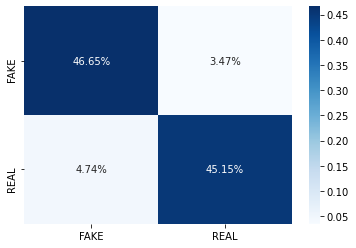

In [94]:
cm_cat = confusion_matrix(test['label'], test_count_pred_cat, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_cat/ np.sum(cm_cat),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL'])


In [95]:
from sklearn.metrics import classification_report

count_report_cat = classification_report(test['label'], test_count_pred_cat, labels = ['FAKE','REAL'], output_dict = True)
count_report_cat = pd.DataFrame(count_report_cat).transpose()
count_report_cat

,precision,recall,f1-score,support
FAKE,0.907834,0.930709,0.919129,635.000000
REAL,0.928571,0.905063,0.916667,632.000000
accuracy,0.917916,0.917916,0.917916,0.917916
macro avg,0.918203,0.917886,0.917898,1267.000000
weighted avg,0.918178,0.917916,0.917901,1267.000000
